In [55]:

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import os
import pandas as pd
from time import time
import matplotlib.pyplot as plt
# from binarized_modules import  BinarizeLinear,BinarizeConv2d

In [56]:
import os
# os.chdir("/home/earapidis/Desktop/BinaryNet.pytorch")
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [57]:
import models.binarized_modules

In [58]:
import importlib
importlib.reload(models.binarized_modules)

<module 'models.binarized_modules' from '/shares/bulk/earapidis/dev/BinarizedNN/models/binarized_modules.py'>

In [59]:
from models.binarized_modules import  BinarizeLinear,BinarizeConv2d
from models.binarized_modules import  Binarize,HingeLoss


In [60]:
# cuda = False
cuda = True

In [61]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [62]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [63]:
test_batch_size=1000

In [64]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [65]:
import models.lenet_5
import models.mlp

importlib.reload(models.lenet_5)
importlib.reload(models.mlp)

<module 'models.mlp' from '/shares/bulk/earapidis/dev/BinarizedNN/models/mlp.py'>

In [66]:
# from models.lenet_5 import BinarizedLeNet5_NoBN as Net
# from models.lenet_5 import BinarizedLeNet5_BN as Net
from models.mlp import MLP as Net

In [67]:
# from mnist_bnn import Net

model = Net()
# model = Net()
if cuda:
    torch.cuda.set_device(0)
    model.cuda()


In [68]:
lr=0.001

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [70]:
log_interval=100

In [71]:
def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(batch_idx)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        if epoch%40==0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

        optimizer.zero_grad()
        loss.backward()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-1,1))
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [72]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc = 100. * correct / len(test_loader.dataset)
    return acc

In [73]:
epochs=30

In [74]:
os.getcwd()

'/shares/bulk/earapidis/dev/BinarizedNN'

In [75]:
model_sim = 2

working_dir = os.getcwd()
save_dir = os.path.join(working_dir,"saved_models/mlp")
# save_dir = os.path.join(working_dir,"saved_models/lenet_5")
# save_dir = os.path.abspath("/shares/bulk/earapidis/saved_models")
models_path = os.path.join(save_dir,f"model_{model_sim}")

os.makedirs(models_path,exist_ok=True)


Train Epoch: 1 [0/60000 (0%)]	Loss: 7.908932
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.177587
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.723384
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.028586
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.634387
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.076568
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.487023
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.463203
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.774207
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.366538

Test set: Average loss: 0.0006, Accuracy: 8935/10000 (89%)

[7.908932209014893, 5.662222385406494, 5.156828880310059, 3.025432825088501, 3.46742844581604, 1.951513409614563, 2.541198492050171, 2.753321886062622, 2.8313956260681152, 3.765446901321411, 2.647587299346924, 2.4463815689086914, 3.5636892318725586, 2.3352210521698, 2.2076847553253174, 2.0193612575531006, 1.4883582592010498, 1.617051601409912, 1.1927345991134644, 1.3405134677886963, 2.65501070022583, 2.159508466720581, 1.5650246143341064, 0.

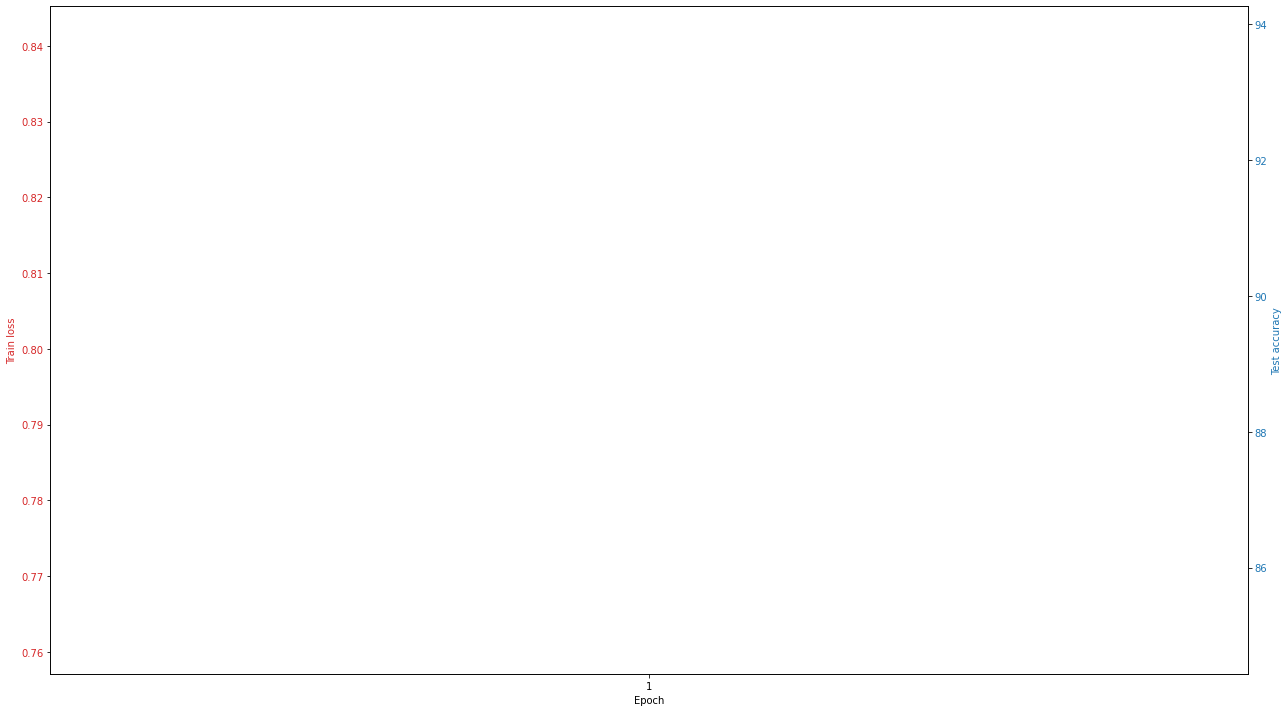

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_1.pth
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.968761
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.602532
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.155819
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.394993
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.369593
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.265807
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.570620
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.656553
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.499193
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.126563

Test set: Average loss: 0.0005, Accuracy: 9078/10000 (91%)

[0.9687610268592834, 0.8515629768371582, 0.5569396018981934, 0.2752021253108978, 0.5265445113182068, 0.5372336506843567, 0.33999454975128174, 0.599545419216156, 0.423785537481308, 0.855285108089447, 1.1466118097305298, 0.5767816305160522, 1.413744568824768, 1.2199935913085938, 0.5623391270637512, 0.4378015100955963, 0.40260812640190125, 0.3244567215442657

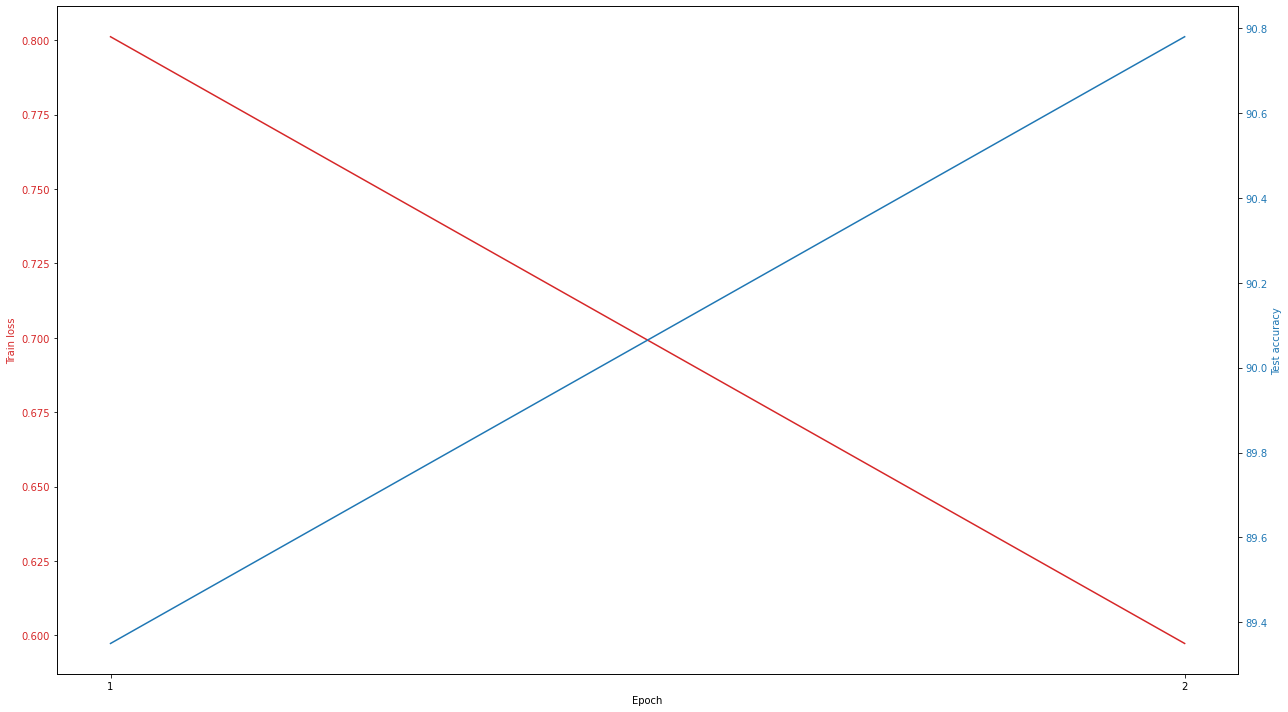

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_2.pth
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.135153
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.583512
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.517822
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.384161
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.439435
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.487121
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.328618
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.537742
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.687136
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.475317

Test set: Average loss: 0.0006, Accuracy: 8931/10000 (89%)

[0.13515324890613556, 0.6125735640525818, 1.045870065689087, 0.11623257398605347, 0.5837690234184265, 0.43650680780410767, 0.5989494323730469, 0.3702491223812103, 0.5032837390899658, 0.7567525506019592, 0.0780714601278305, 0.4904868006706238, 0.6733123064041138, 0.637134850025177, 0.4832441210746765, 0.4128633737564087, 0.4710105359554291, 0.2449209094047

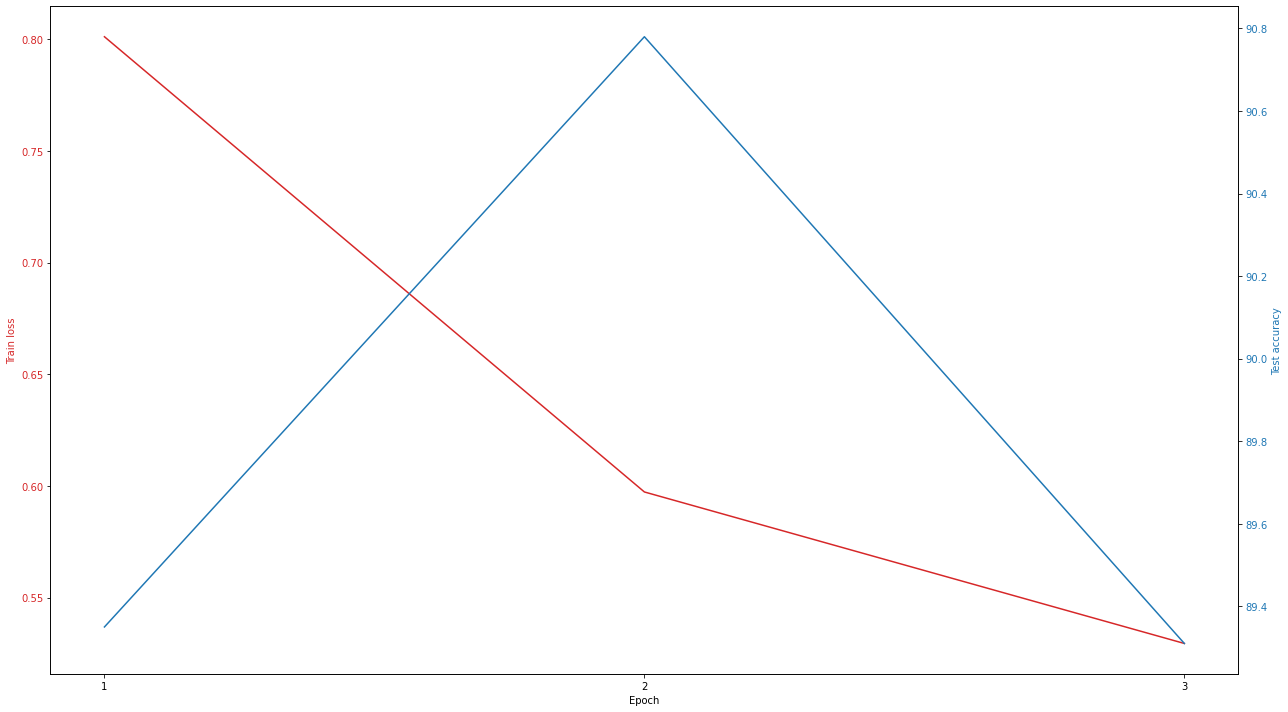

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_3.pth
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.039971
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.207070
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.695181
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.827530
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.126386
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.495269
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.295446
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.760567
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.716994
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.402427

Test set: Average loss: 0.0005, Accuracy: 9228/10000 (92%)

[1.0399705171585083, 0.38008585572242737, 0.4356226921081543, 0.3901640474796295, 0.3253129720687866, 0.6835539937019348, 0.6196616888046265, 0.4854450523853302, 0.2869934141635895, 0.154320627450943, 0.25158432126045227, 1.0254846811294556, 0.22404834628105164, 0.11183425039052963, 0.46619197726249695, 0.049637556076049805, 0.3410182595252991, 0.54500389

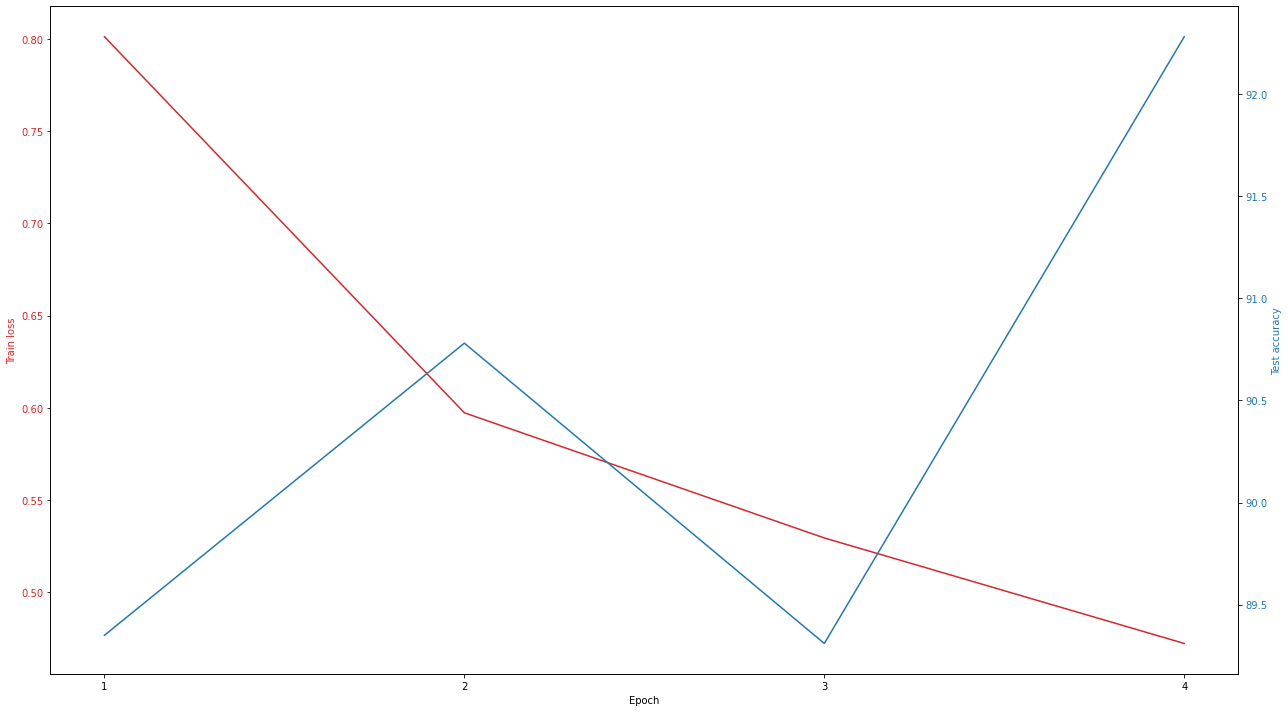

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_4.pth
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.461749
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.724356
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.557559
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.143185
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.270865
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.556756
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.292039
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.354750
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.980926
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.448795

Test set: Average loss: 0.0004, Accuracy: 9177/10000 (92%)

[0.46174943447113037, 0.44472256302833557, 0.4009494185447693, 0.3908984065055847, 0.7497353553771973, 0.4915952682495117, 0.4385891854763031, 0.2872830629348755, 0.5332044959068298, 0.3782667815685272, 0.588821291923523, 0.455965131521225, 0.07655373215675354, 0.7656040787696838, 0.577075183391571, 0.3939974904060364, 0.32756757736206055, 0.3586131334304

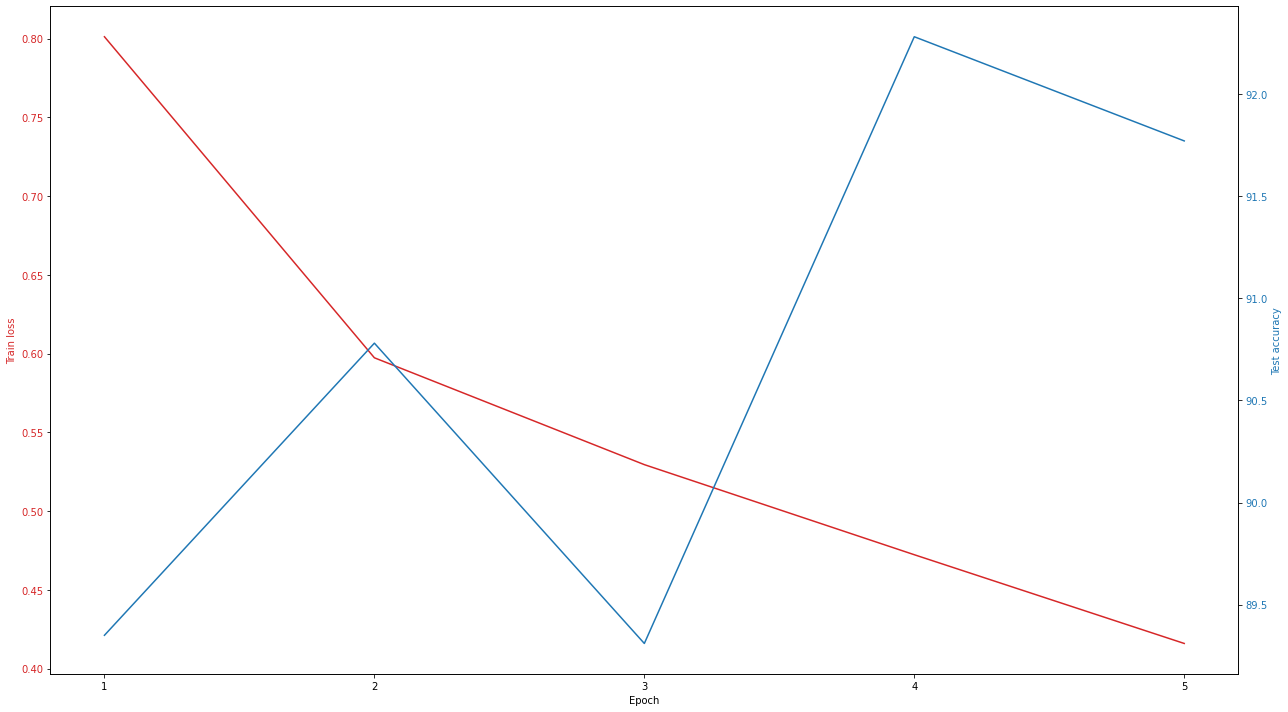

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_5.pth
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.330822
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.197572
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.507128
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.137278
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.333278
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.484731
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.219090
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.250930
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.295318
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.597540

Test set: Average loss: 0.0005, Accuracy: 9113/10000 (91%)

[0.33082225918769836, 0.3047212064266205, 0.17453038692474365, 0.14209721982479095, 1.1155657768249512, 0.3954867720603943, 0.336541086435318, 0.387968510389328, 0.6835635304450989, 0.14452925324440002, 0.054846275597810745, 0.4243341386318207, 0.5511645674705505, 0.26575762033462524, 0.25770139694213867, 0.11743492633104324, 0.23021677136421204, 0.347672

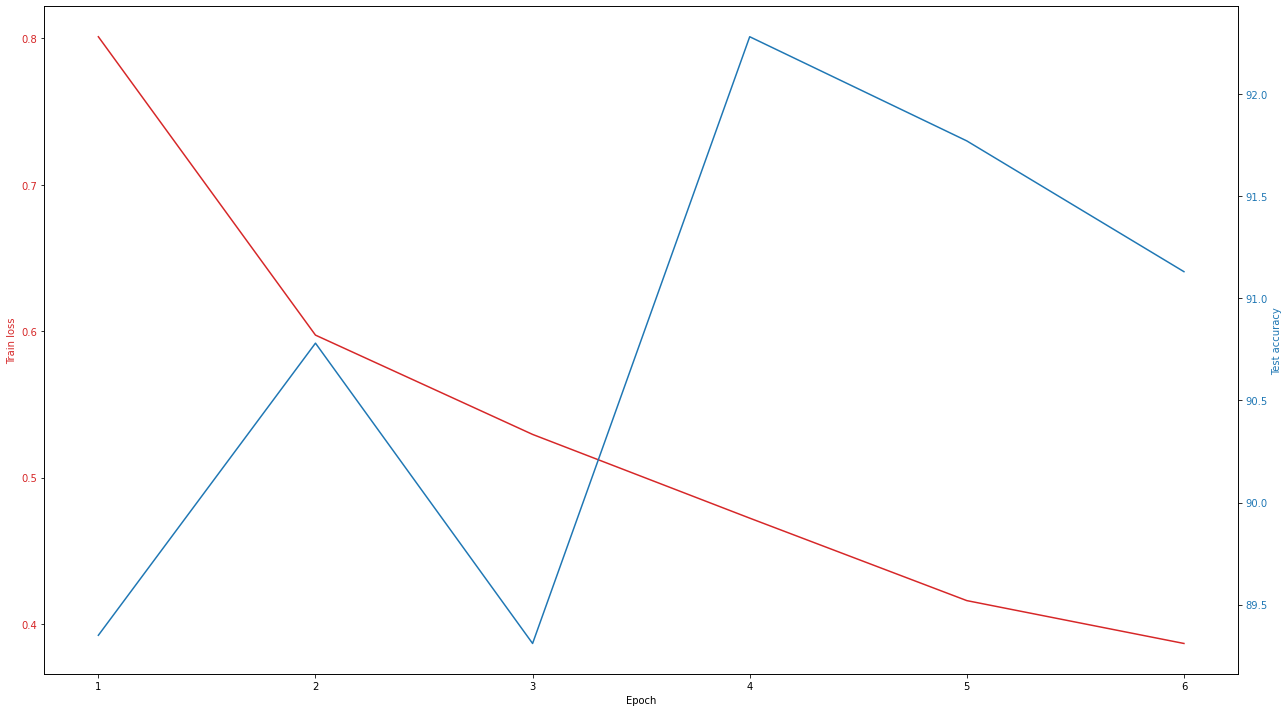

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_6.pth
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.543041
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.342312
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.304414
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.256477
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.111611
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.383507
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.381962
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.356994
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.371070
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.247400

Test set: Average loss: 0.0004, Accuracy: 9362/10000 (94%)

[0.5430406928062439, 0.3102510869503021, 0.7549592852592468, 0.593791127204895, 0.5814651250839233, 0.7489169239997864, 0.3838188052177429, 0.5340384244918823, 0.4344797134399414, 0.6019694209098816, 0.39743080735206604, 0.1677045375108719, 0.21359294652938843, 0.5201566815376282, 0.2529764473438263, 0.5535369515419006, 0.31254997849464417, 0.051407095044

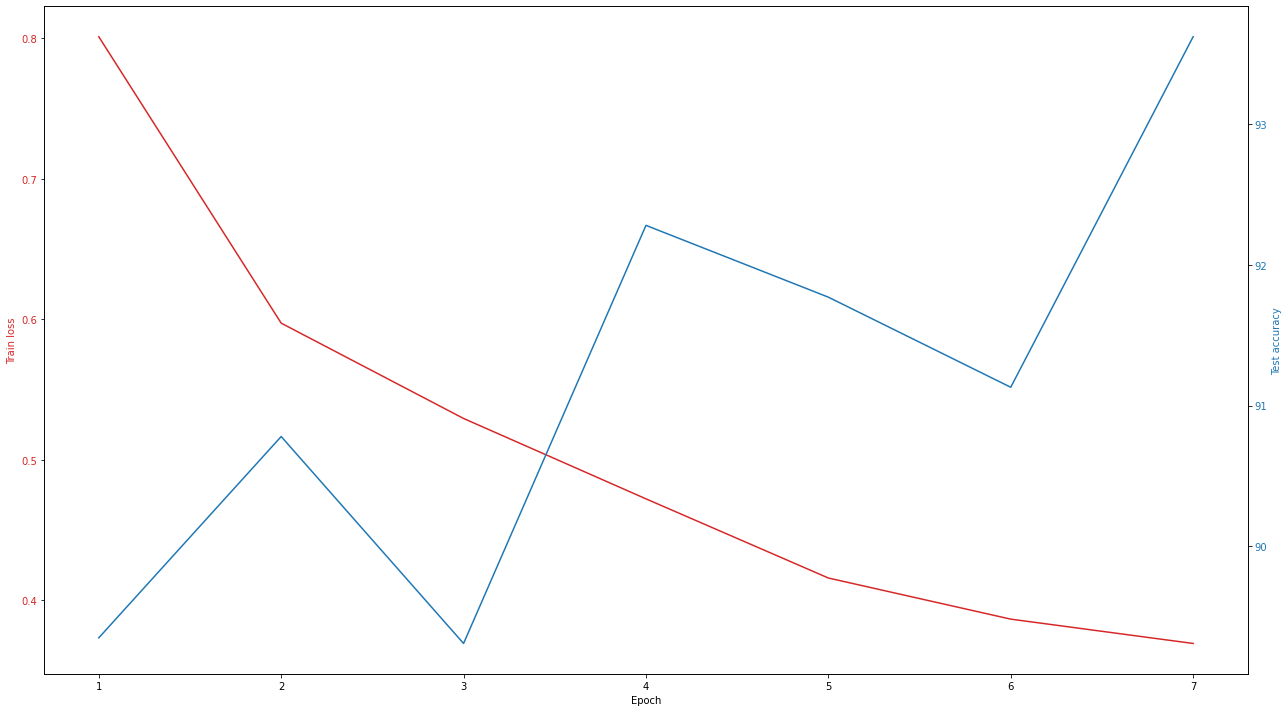

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_7.pth
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.522835
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.323519
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.426156
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.207093
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.216175
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.219222
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.390516
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.047164
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.262481
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.246211

Test set: Average loss: 0.0004, Accuracy: 9272/10000 (93%)

[0.5228345394134521, 0.09523913264274597, 0.46245312690734863, 0.4169856905937195, 0.43186941742897034, 0.41779881715774536, 0.25920403003692627, 0.017016908153891563, 0.08532319962978363, 0.6952479481697083, 0.024335306137800217, 0.5094449520111084, 0.4322553873062134, 0.26980090141296387, 0.35733065009117126, 0.742879331111908, 0.5332503318786621, 0.242

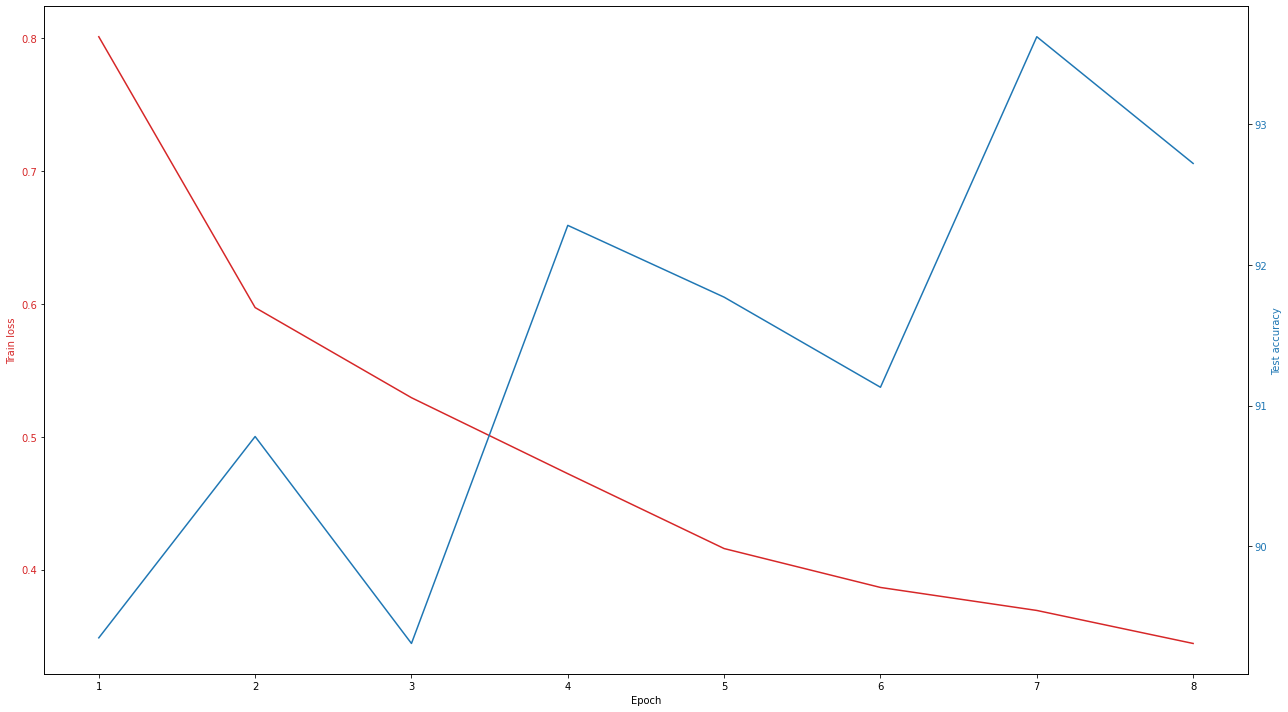

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_8.pth
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.685178
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.505433
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.242239
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.270562
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.996947
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.113770
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.471935
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.191613
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.141782
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.107945

Test set: Average loss: 0.0004, Accuracy: 9388/10000 (94%)

[0.6851780414581299, 0.31629806756973267, 0.41495251655578613, 0.3676440715789795, 0.049748439341783524, 0.029752515256404877, 0.1208435669541359, 0.23203152418136597, 0.13307985663414001, 0.47879964113235474, 0.38353756070137024, 0.16608858108520508, 0.23270048201084137, 0.21719518303871155, 0.155111163854599, 0.5259473919868469, 0.1972162127494812, 0.08

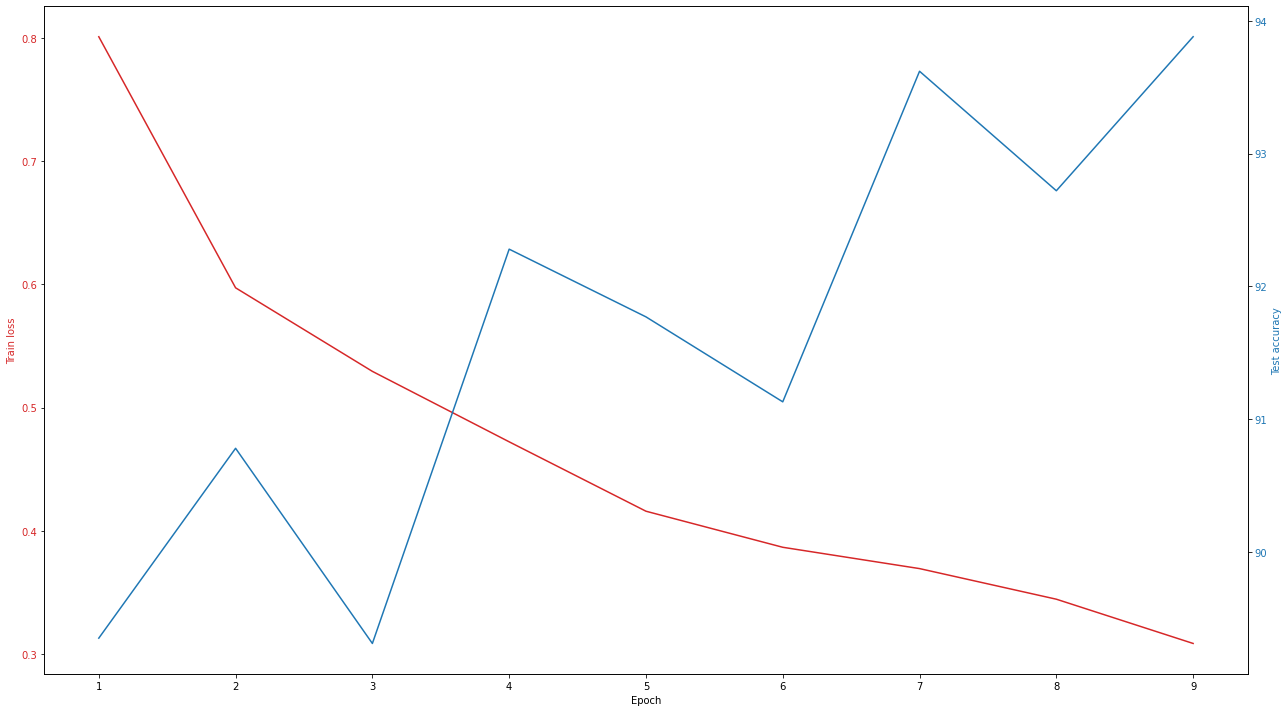

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_9.pth
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.019133
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.408718
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.250891
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.518688
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.416652
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.271249
Train Epoch: 10 [38400/60000 (64%)]	Loss: 1.236302
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.245480
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.280317
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.032502

Test set: Average loss: 0.0003, Accuracy: 9473/10000 (95%)

[0.01913275569677353, 0.6306078433990479, 0.10911966860294342, 0.016285335645079613, 0.21808679401874542, 0.19635215401649475, 0.45452532172203064, 0.06370611488819122, 0.09483310580253601, 0.6135740876197815, 0.24088048934936523, 0.14111784100532532, 0.2007378190755844, 0.5287361741065979, 0.11033320426940918, 0.1370221972465515, 0.172534182667

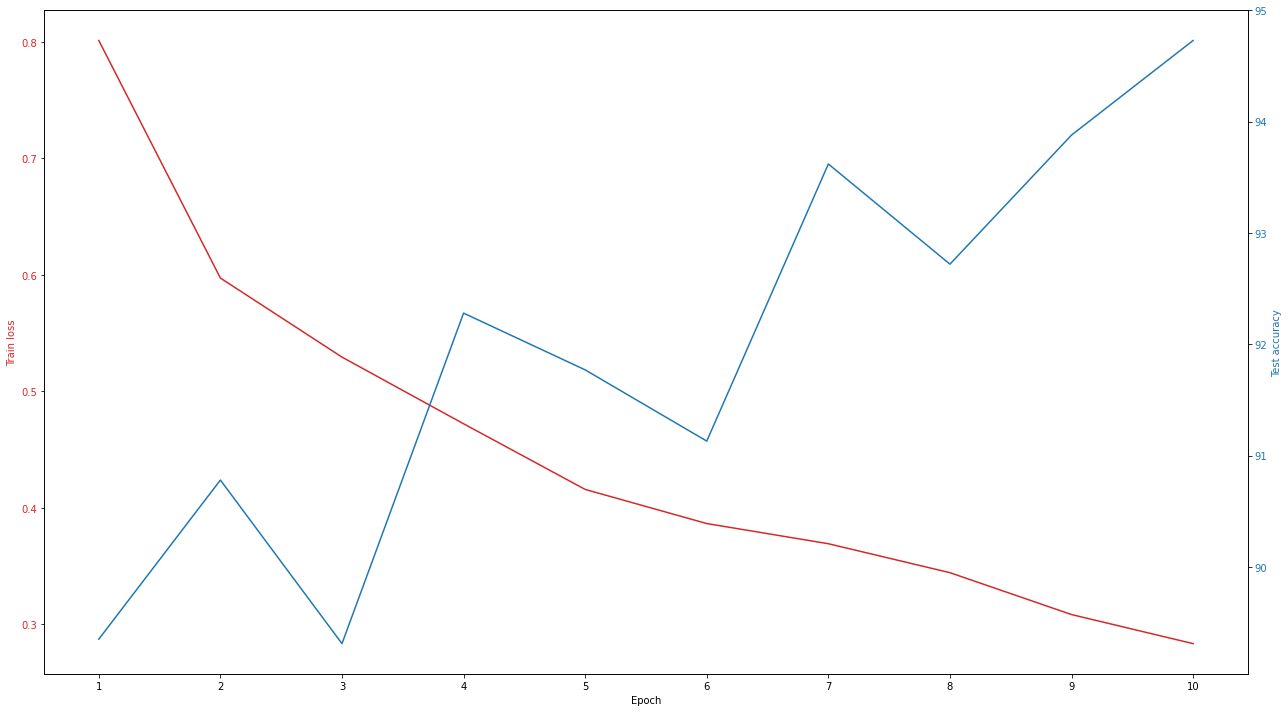

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_10.pth
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.093639
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.236954
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.374120
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.041117
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.119253
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.712103
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.117278
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.097331
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.353556
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.125016

Test set: Average loss: 0.0003, Accuracy: 9467/10000 (95%)

[0.09363933652639389, 0.052746400237083435, 0.14864860475063324, 0.12198150902986526, 0.5314385294914246, 0.183644637465477, 0.18122172355651855, 0.19014759361743927, 0.07633177191019058, 0.7165351510047913, 0.16154947876930237, 0.10364867746829987, 0.21960578858852386, 0.23178614675998688, 0.11758055537939072, 0.11462140828371048, 0.6713567376

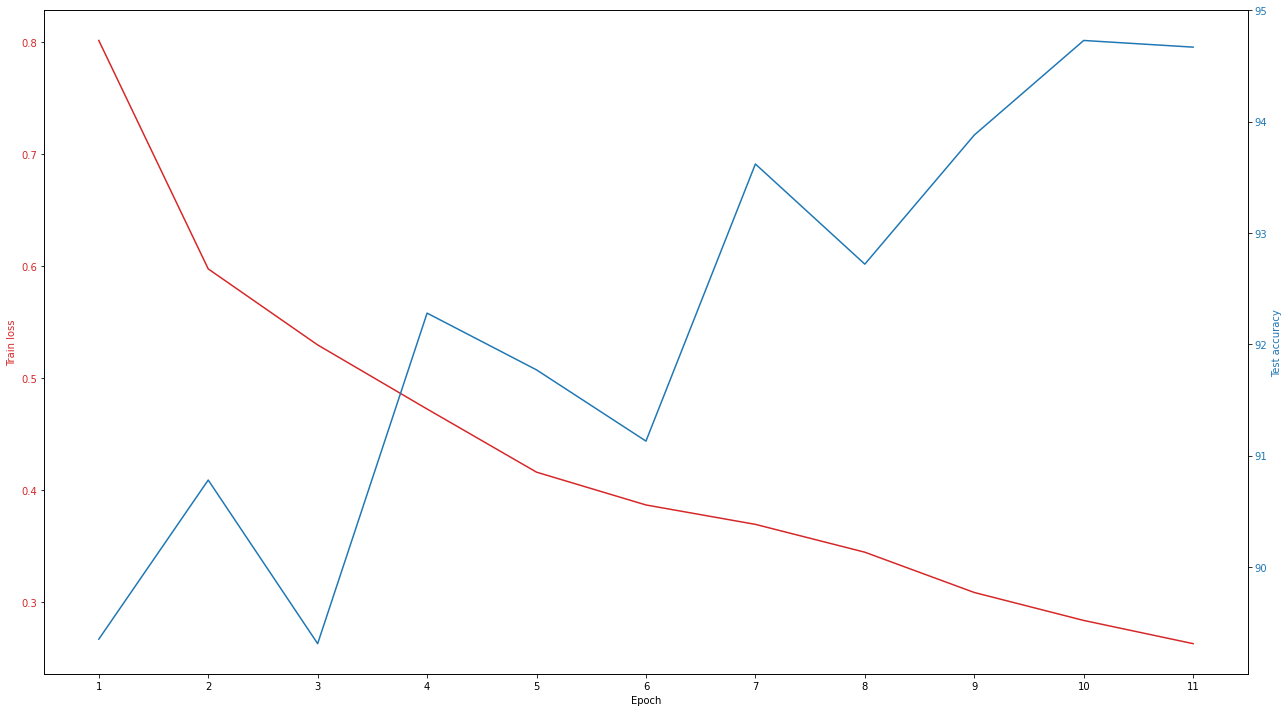

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_11.pth
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.364363
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.232608
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.596424
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.230352
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.119693
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.124860
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.291663
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.429218
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.188336
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.843242

Test set: Average loss: 0.0003, Accuracy: 9396/10000 (94%)

[0.364362508058548, 0.47419190406799316, 0.16175153851509094, 0.318212628364563, 0.5279081463813782, 0.16020238399505615, 0.021486269310116768, 0.24708829820156097, 0.28015708923339844, 0.02047618478536606, 0.05888825282454491, 0.25980332493782043, 0.013015278615057468, 0.29094451665878296, 0.053407538682222366, 0.11874803900718689, 0.707890093

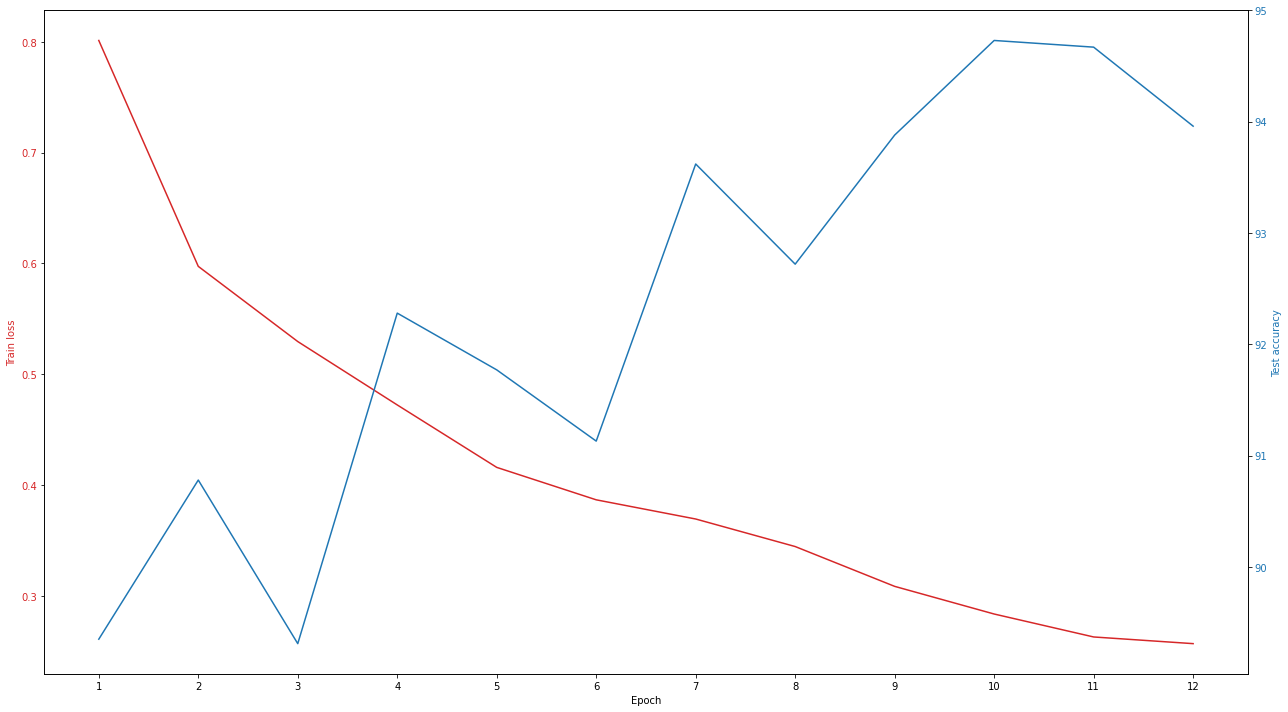

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_12.pth
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.213450
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.338514
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.005741
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.020563
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.090152
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.048775
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.250565
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.188095
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.516805
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.571949

Test set: Average loss: 0.0003, Accuracy: 9500/10000 (95%)

[0.21344952285289764, 0.553471028804779, 0.08462917059659958, 0.2502351999282837, 0.16688069701194763, 0.20222023129463196, 0.3571229875087738, 0.4091099500656128, 0.3209349811077118, 0.5898246169090271, 0.4709605574607849, 0.30387061834335327, 0.2878301739692688, 0.05974937975406647, 0.08029123395681381, 0.1142539232969284, 0.18069732189178467

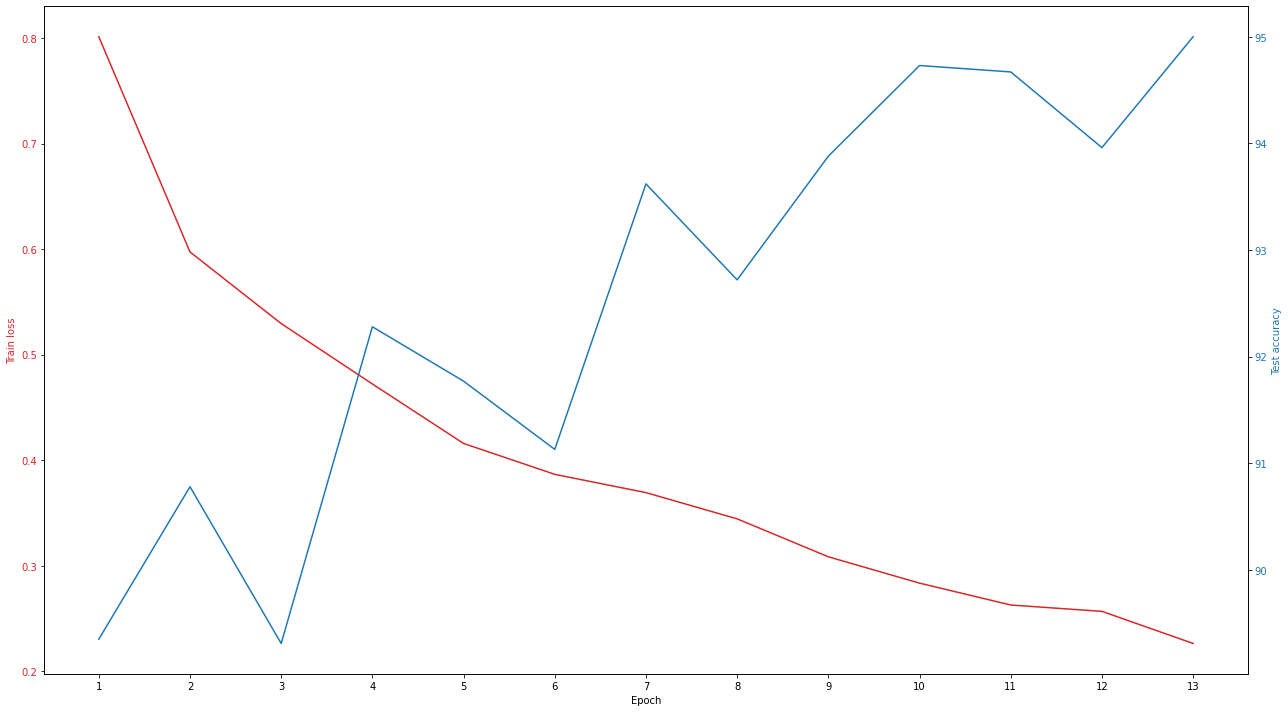

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_13.pth
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.166039
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.413560
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.309606
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.252284
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.086665
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.249218
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.262537
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.676960
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.351091
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.085903

Test set: Average loss: 0.0004, Accuracy: 9401/10000 (94%)

[0.1660390943288803, 0.0691157802939415, 0.3096557855606079, 0.12229123711585999, 0.07260977476835251, 0.18985676765441895, 0.16998480260372162, 0.31634992361068726, 0.048393648117780685, 0.19296063482761383, 0.32154613733291626, 0.14520059525966644, 0.10332287847995758, 0.18040090799331665, 0.16720065474510193, 0.02012619376182556, 0.240801468

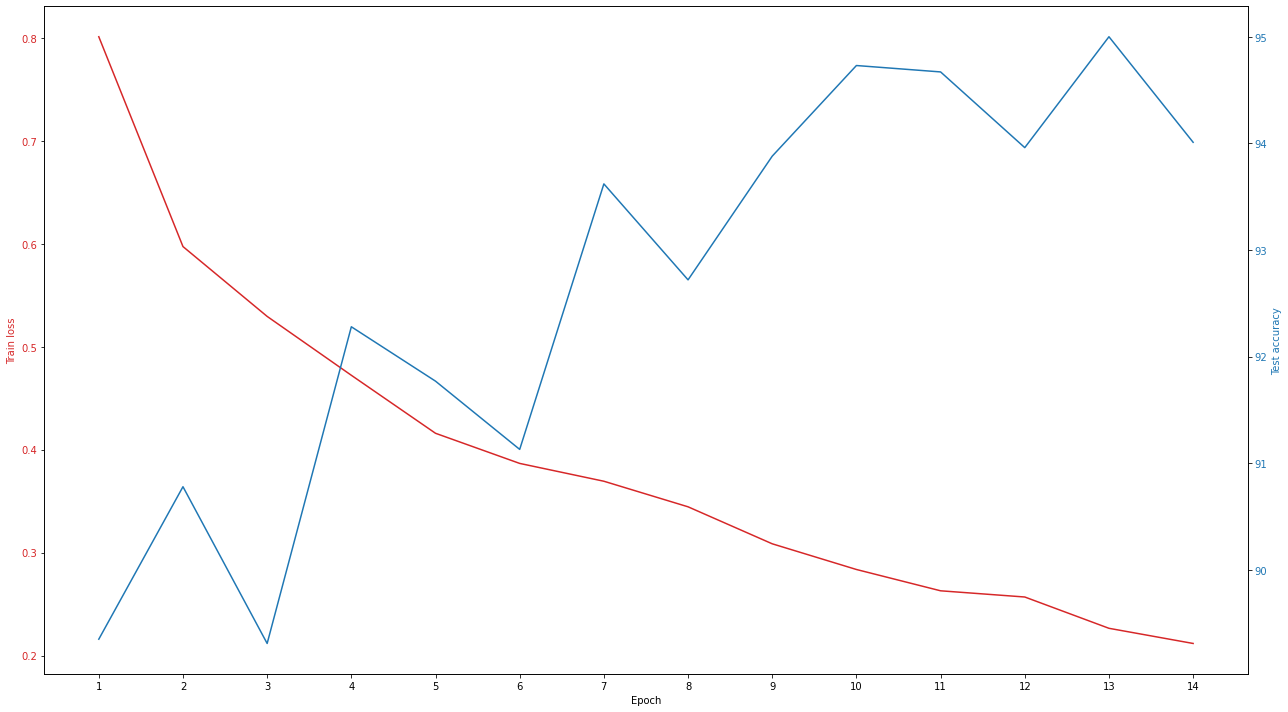

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_14.pth
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.231761
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.273320
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.127186
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.268139
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.101266
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.231753
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.006364
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.258955
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.214810
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.037937

Test set: Average loss: 0.0003, Accuracy: 9464/10000 (95%)

[0.2317608892917633, 0.12296005338430405, 0.7678627371788025, 0.010266545228660107, 0.5700576901435852, 0.05008513107895851, 0.06568129360675812, 0.21130751073360443, 0.14071382582187653, 0.3367675542831421, 0.34043198823928833, 0.39164459705352783, 0.07662124186754227, 0.35148027539253235, 0.49192821979522705, 0.21978254616260529, 0.3073132038

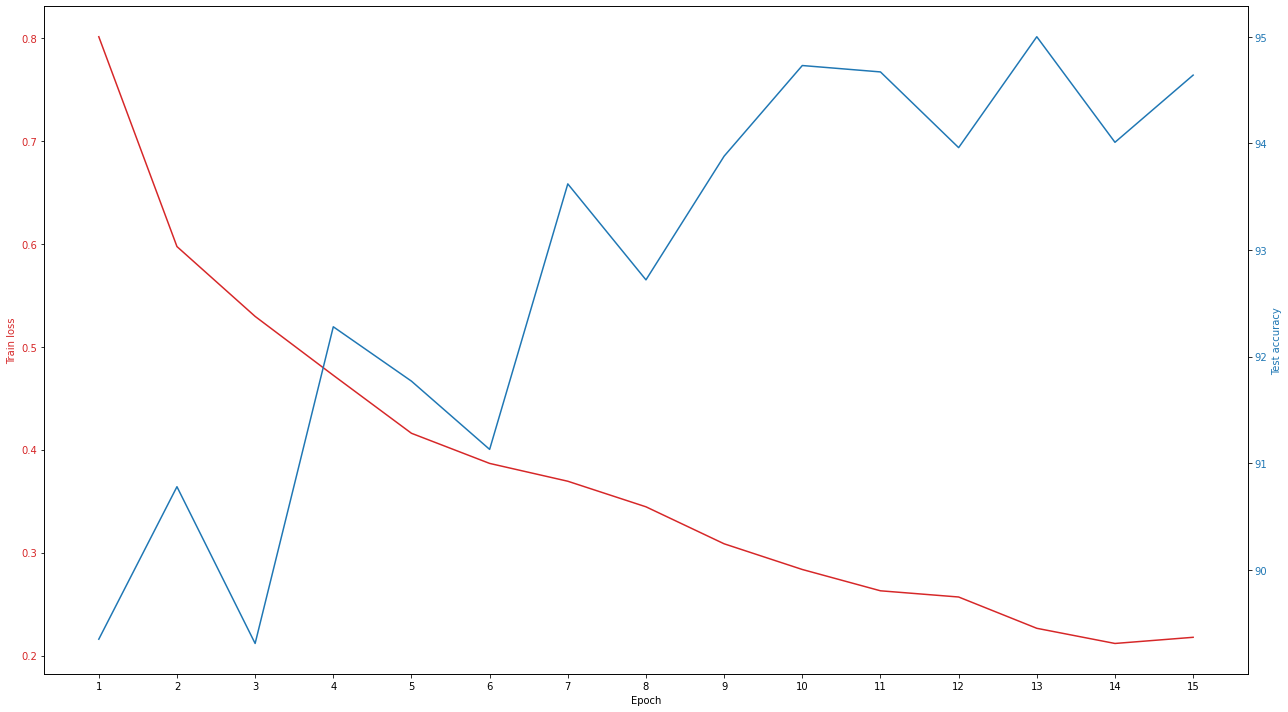

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_15.pth
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.337554
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.041036
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.348456
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.305857
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.448822
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.231335
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.226851
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.381989
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.042998
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.236274

Test set: Average loss: 0.0003, Accuracy: 9503/10000 (95%)

[0.3375537097454071, 0.08722661435604095, 0.21645063161849976, 0.008795417845249176, 0.2708010971546173, 0.027718178927898407, 0.17200371623039246, 0.07506179064512253, 0.011815782636404037, 0.05455943942070007, 0.47988682985305786, 0.08950622379779816, 0.1326902061700821, 0.10672198235988617, 0.22816252708435059, 0.3702596426010132, 0.46004500

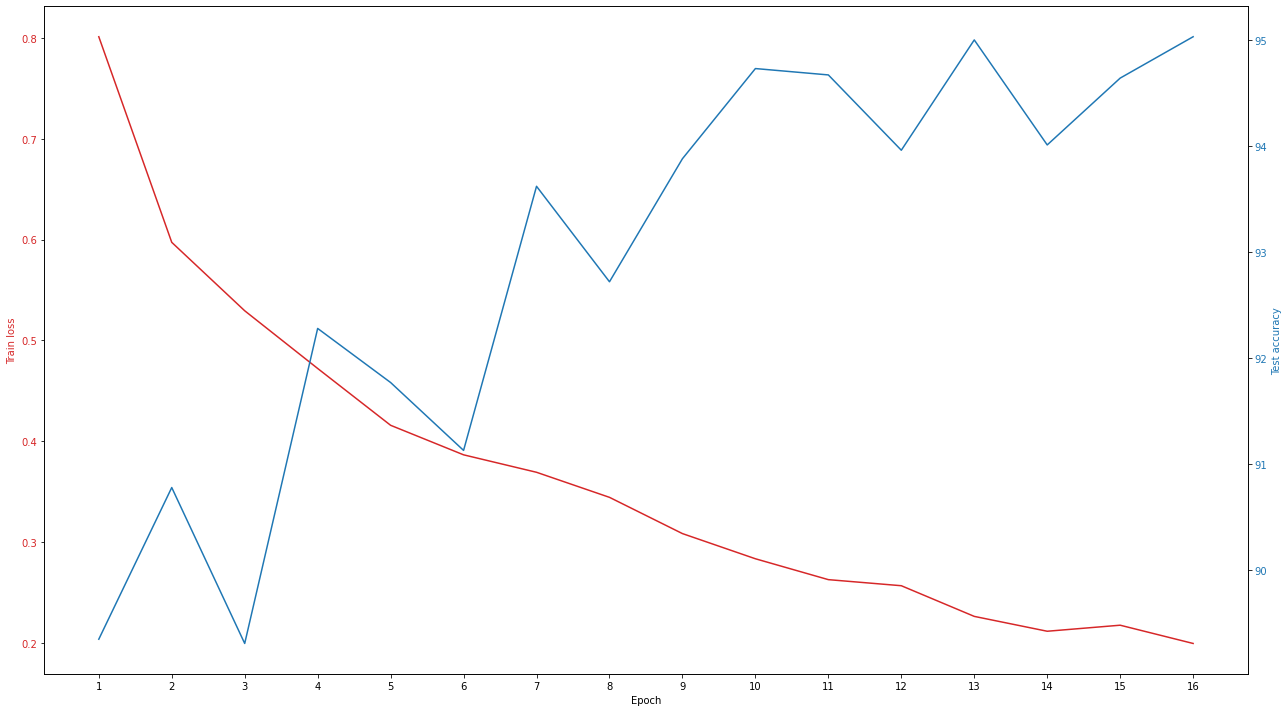

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_16.pth
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.128736
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.155196
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.205450
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.106572
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.271878
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.011916
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.465965
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.111601
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.468232
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.087764

Test set: Average loss: 0.0004, Accuracy: 9458/10000 (95%)

[0.12873609364032745, 0.24340417981147766, 0.1901383250951767, 0.26268240809440613, 0.23847834765911102, 0.7655370235443115, 0.0919787809252739, 0.05249793827533722, 0.0069474121555686, 0.11608483642339706, 0.038786452263593674, 0.217392235994339, 0.0671921819448471, 0.10155646502971649, 0.3425331711769104, 0.12792149186134338, 0.15195401012897

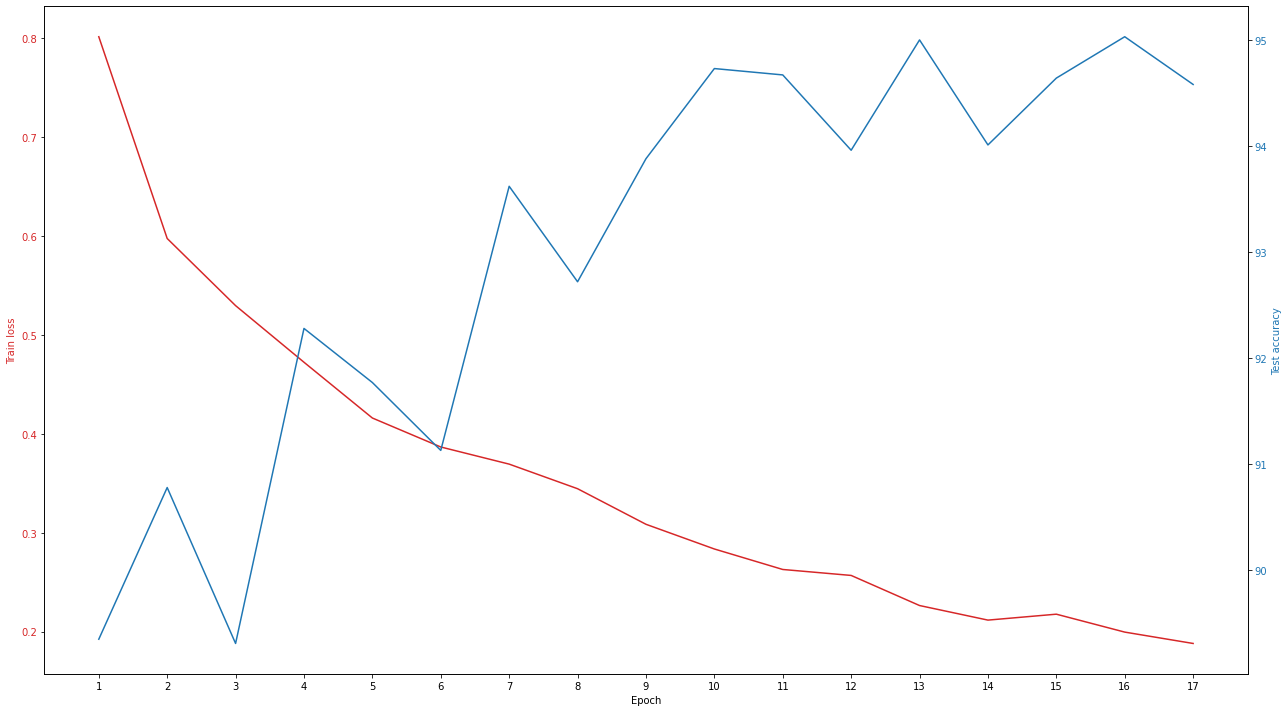

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_17.pth
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.102230
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.393865
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.073672
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.082824
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.134050
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.086738
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.075641
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.114706
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.126063
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.360502

Test set: Average loss: 0.0003, Accuracy: 9544/10000 (95%)

[0.10223008692264557, 0.27280375361442566, 0.052264634519815445, 0.13146492838859558, 0.026628032326698303, 0.0395352765917778, 0.19051414728164673, 0.684021532535553, 0.1674436628818512, 0.021172625944018364, 0.09926019608974457, 0.14683480560779572, 0.1290273219347, 0.0695825070142746, 0.09784747660160065, 0.009852350689470768, 0.067575566470

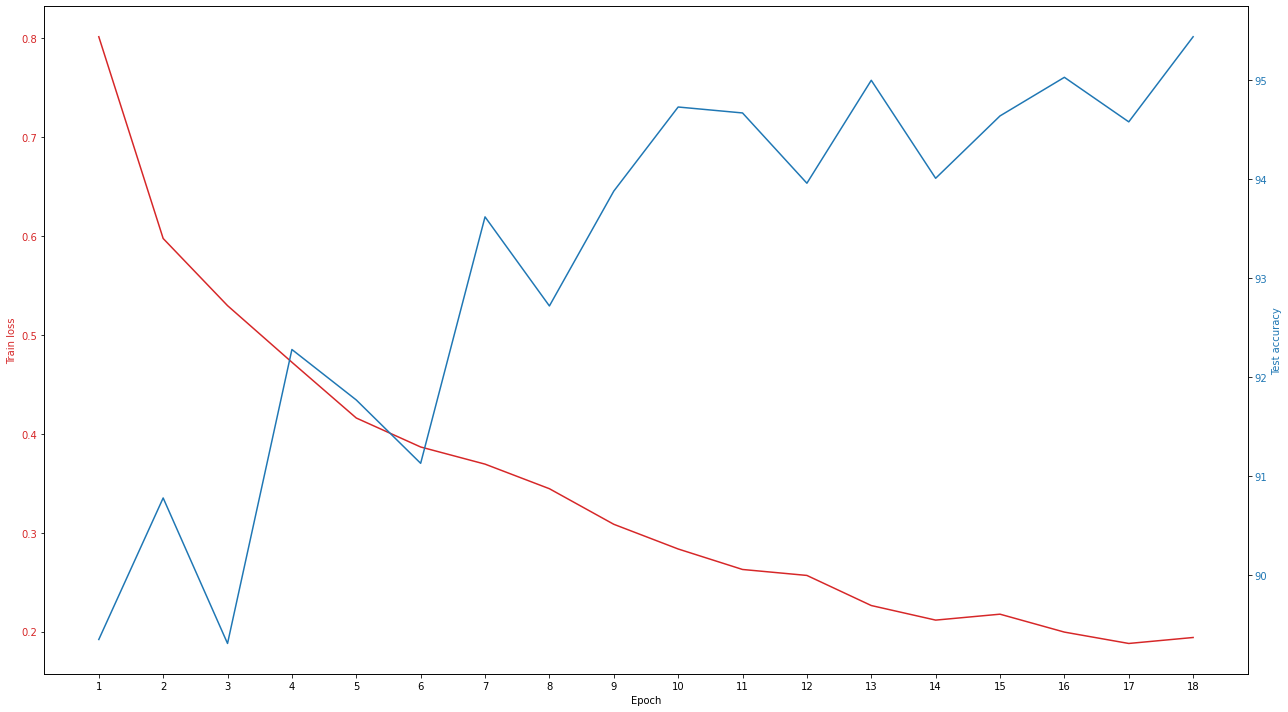

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_18.pth
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.087853
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.020816
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.102330
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.016101
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.094187
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.012940
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.033760
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.084444
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.191500
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.043701

Test set: Average loss: 0.0003, Accuracy: 9471/10000 (95%)

[0.08785330504179001, 0.500770092010498, 0.011879900470376015, 0.3269961178302765, 0.09844832867383957, 0.23375293612480164, 0.13875094056129456, 0.30518999695777893, 0.28093618154525757, 0.10986179113388062, 0.22704030573368073, 0.44901880621910095, 0.2776859700679779, 0.22270599007606506, 0.20994867384433746, 0.14085929095745087, 0.2648290097

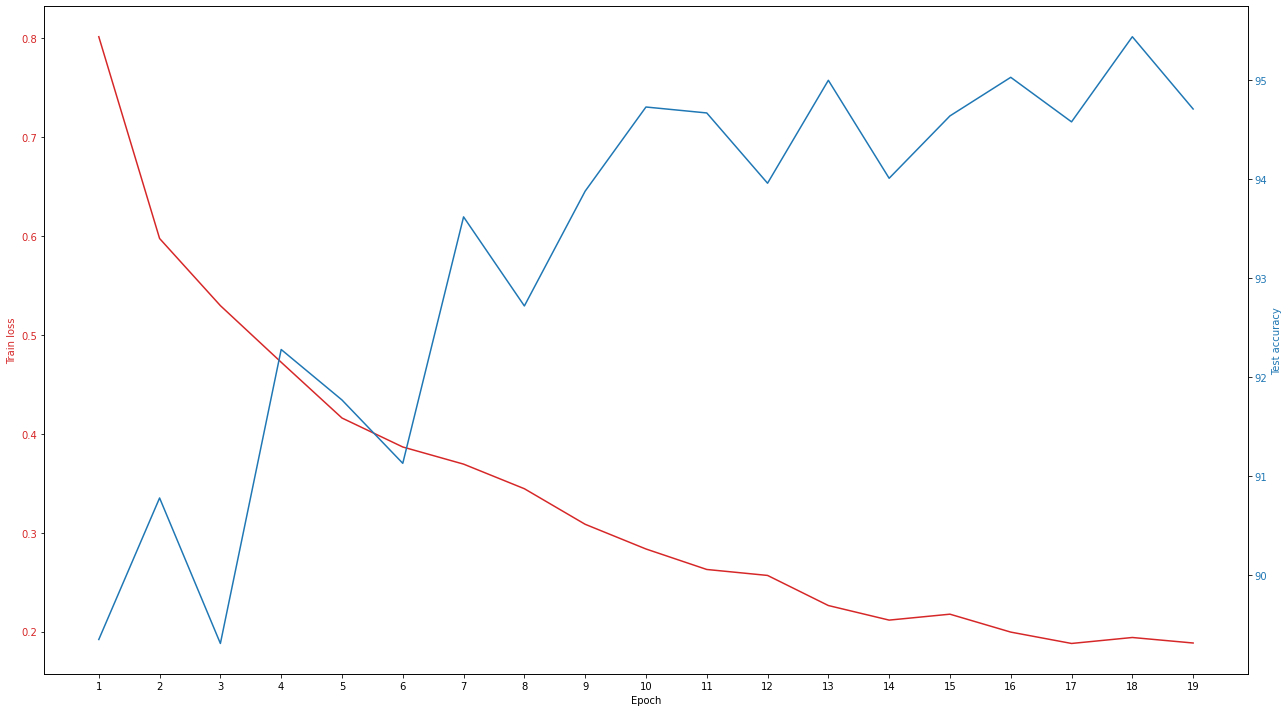

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_19.pth
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.257317
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.076090
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.130039
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.014093
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.078534
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.092943
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.245597
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.011756
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.201652
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.207908

Test set: Average loss: 0.0003, Accuracy: 9515/10000 (95%)

[0.257317453622818, 0.07038702815771103, 0.10248862951993942, 0.09827651083469391, 0.007990441285073757, 0.10694825649261475, 0.0045087505131959915, 0.004608535207808018, 0.11910435557365417, 0.3299119472503662, 0.02586495503783226, 0.3908287286758423, 0.05426793545484543, 0.4175744950771332, 0.0039026709273457527, 0.08046837896108627, 0.199245

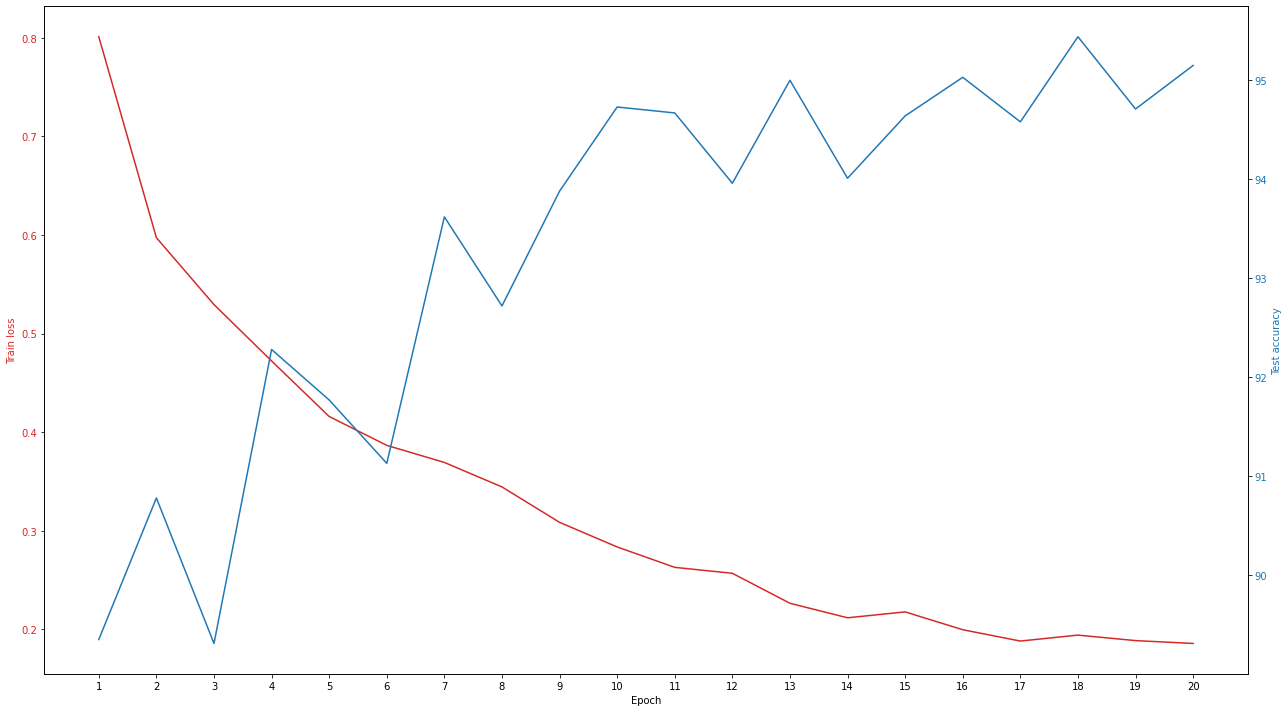

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_20.pth
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.066185
Train Epoch: 21 [6400/60000 (11%)]	Loss: 0.100090
Train Epoch: 21 [12800/60000 (21%)]	Loss: 0.069293
Train Epoch: 21 [19200/60000 (32%)]	Loss: 0.378955
Train Epoch: 21 [25600/60000 (43%)]	Loss: 0.549055
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.647969
Train Epoch: 21 [38400/60000 (64%)]	Loss: 0.157272
Train Epoch: 21 [44800/60000 (75%)]	Loss: 0.427073
Train Epoch: 21 [51200/60000 (85%)]	Loss: 0.496354
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.264868

Test set: Average loss: 0.0003, Accuracy: 9460/10000 (95%)

[0.06618508696556091, 0.005809178575873375, 0.13667866587638855, 0.11423979699611664, 0.08251980692148209, 0.15454234182834625, 0.14586347341537476, 0.10202774405479431, 0.03667014464735985, 0.17723986506462097, 0.14426319301128387, 0.29834455251693726, 0.038112424314022064, 0.6554745435714722, 0.00084034533938393, 0.18475310504436493, 0.547485

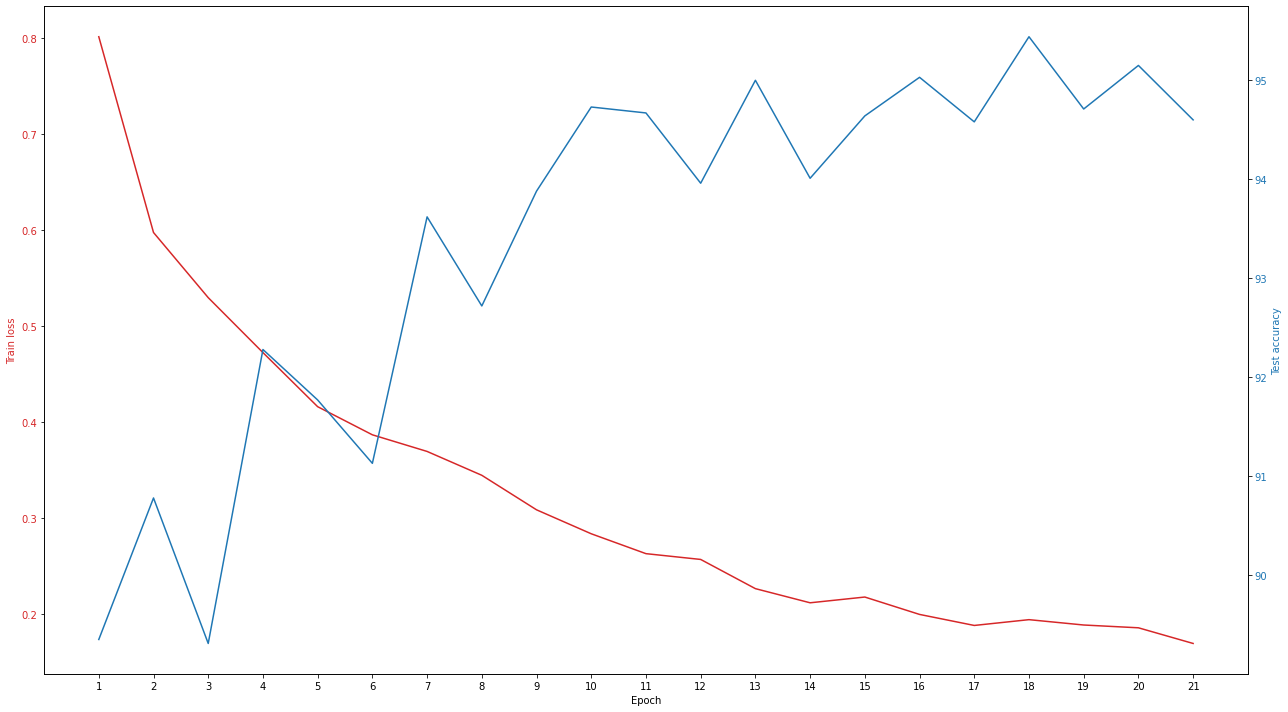

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_21.pth
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.160709
Train Epoch: 22 [6400/60000 (11%)]	Loss: 0.366547
Train Epoch: 22 [12800/60000 (21%)]	Loss: 0.224802
Train Epoch: 22 [19200/60000 (32%)]	Loss: 0.007184
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.108845
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.198882
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.181022
Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.064855
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.056269
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.502142

Test set: Average loss: 0.0003, Accuracy: 9477/10000 (95%)

[0.16070859134197235, 0.1717519313097, 0.25342071056365967, 0.33036524057388306, 0.18941834568977356, 0.12423191964626312, 0.37768450379371643, 0.045737650245428085, 0.23836039006710052, 0.0868760421872139, 0.2844017744064331, 0.23715320229530334, 0.1187378466129303, 0.12074055522680283, 0.22669509053230286, 0.01299862377345562, 0.0457016415894

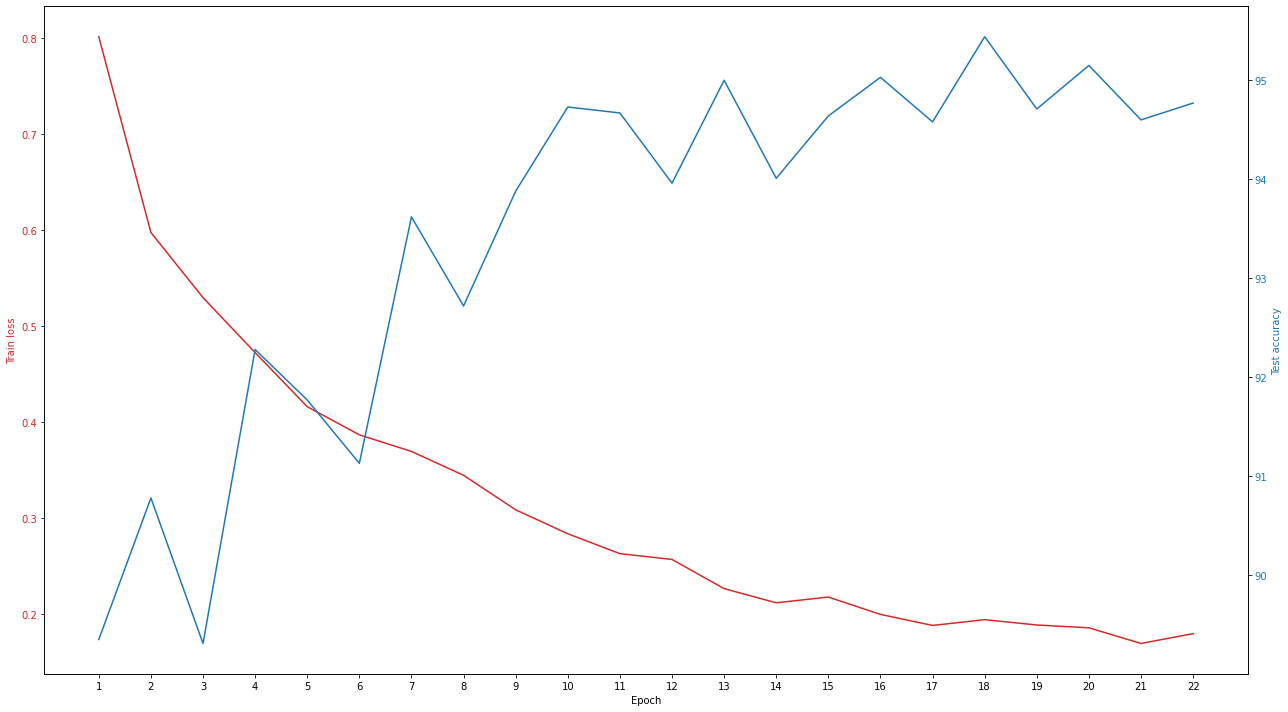

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_22.pth
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.010485
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.061689
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.037131
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.118937
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.243306
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.254478
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.027780
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.211597
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.015831
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.100177

Test set: Average loss: 0.0003, Accuracy: 9552/10000 (96%)

[0.010484556667506695, 0.021117310971021652, 0.10267128050327301, 0.1178245022892952, 0.020964207127690315, 0.029626233503222466, 0.05866461992263794, 0.13390026986598969, 0.2776961922645569, 0.300656795501709, 0.06918364018201828, 0.015988284721970558, 0.26471948623657227, 0.06377410888671875, 0.04621930792927742, 0.13706010580062866, 0.180694

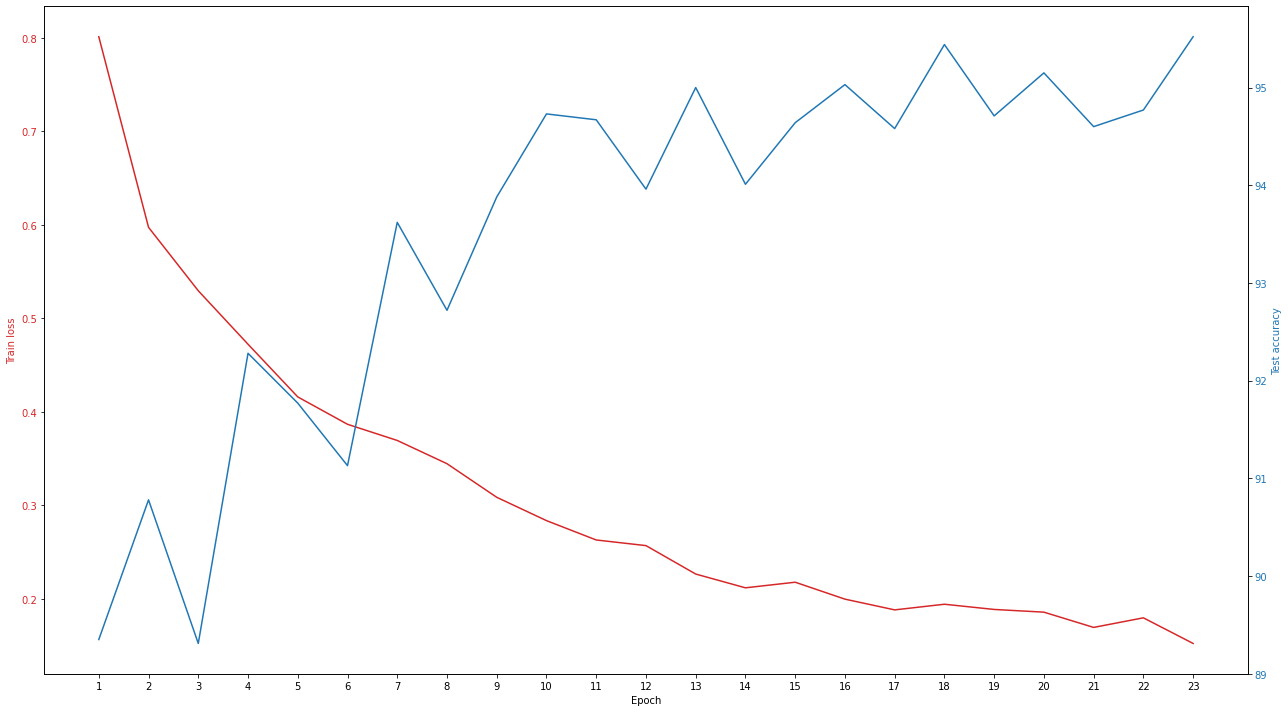

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_23.pth
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.092800
Train Epoch: 24 [6400/60000 (11%)]	Loss: 0.012723
Train Epoch: 24 [12800/60000 (21%)]	Loss: 0.159134
Train Epoch: 24 [19200/60000 (32%)]	Loss: 0.184731
Train Epoch: 24 [25600/60000 (43%)]	Loss: 0.227250
Train Epoch: 24 [32000/60000 (53%)]	Loss: 0.231551
Train Epoch: 24 [38400/60000 (64%)]	Loss: 0.026305
Train Epoch: 24 [44800/60000 (75%)]	Loss: 0.063620
Train Epoch: 24 [51200/60000 (85%)]	Loss: 0.167865
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.015589

Test set: Average loss: 0.0003, Accuracy: 9546/10000 (95%)

[0.09280003607273102, 0.010533398017287254, 0.31149885058403015, 0.14149752259254456, 0.11763331294059753, 0.05010243132710457, 0.003867196384817362, 0.33124783635139465, 0.14525282382965088, 0.19281649589538574, 0.015993323177099228, 0.22367900609970093, 0.06013379245996475, 0.0671040341258049, 0.1375851333141327, 0.1474533975124359, 0.0035591

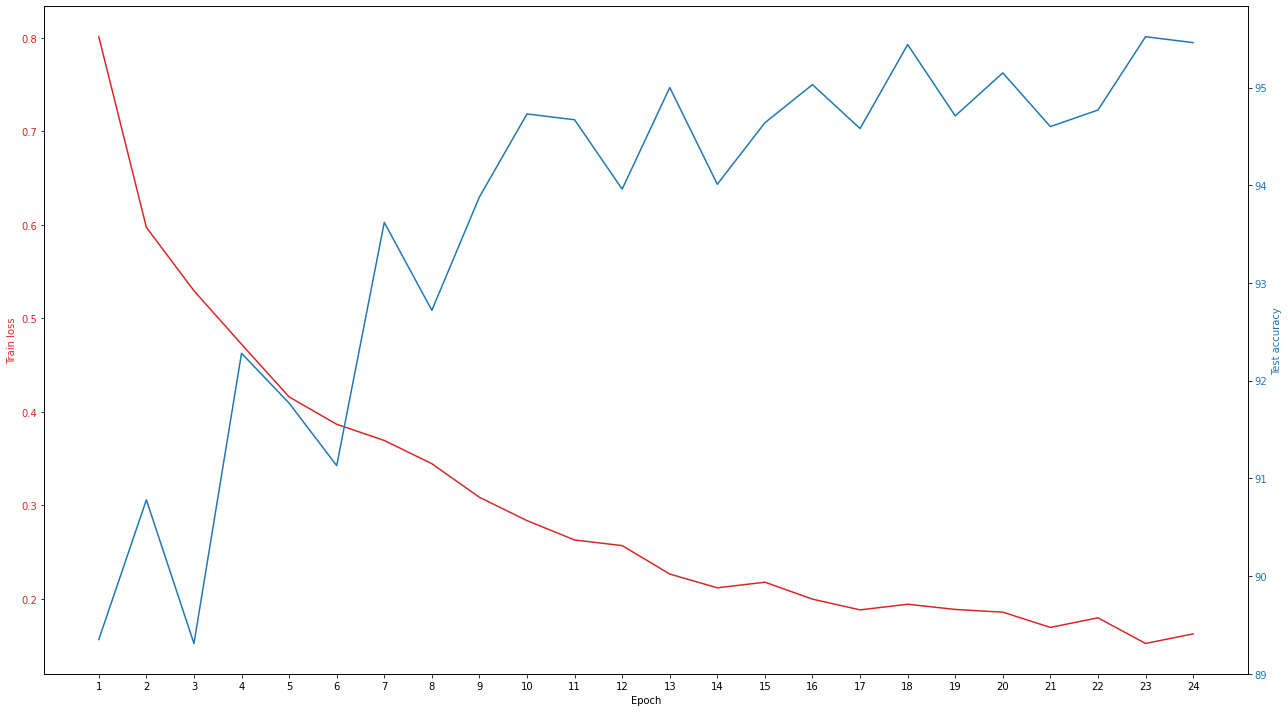

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_24.pth
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.004711
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.208891
Train Epoch: 25 [12800/60000 (21%)]	Loss: 0.185507
Train Epoch: 25 [19200/60000 (32%)]	Loss: 0.091205
Train Epoch: 25 [25600/60000 (43%)]	Loss: 0.163303
Train Epoch: 25 [32000/60000 (53%)]	Loss: 0.112491
Train Epoch: 25 [38400/60000 (64%)]	Loss: 0.104513
Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.301966
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.118698
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.073178

Test set: Average loss: 0.0003, Accuracy: 9485/10000 (95%)

[0.004710886627435684, 0.0962805226445198, 0.332816481590271, 0.008389838971197605, 0.004568739794194698, 0.021481012925505638, 0.1347825676202774, 0.041673582047224045, 0.14568062126636505, 0.02607940509915352, 0.4182974398136139, 0.13144376873970032, 0.05506547912955284, 0.15476521849632263, 0.15245574712753296, 0.11860069632530212, 0.1810358

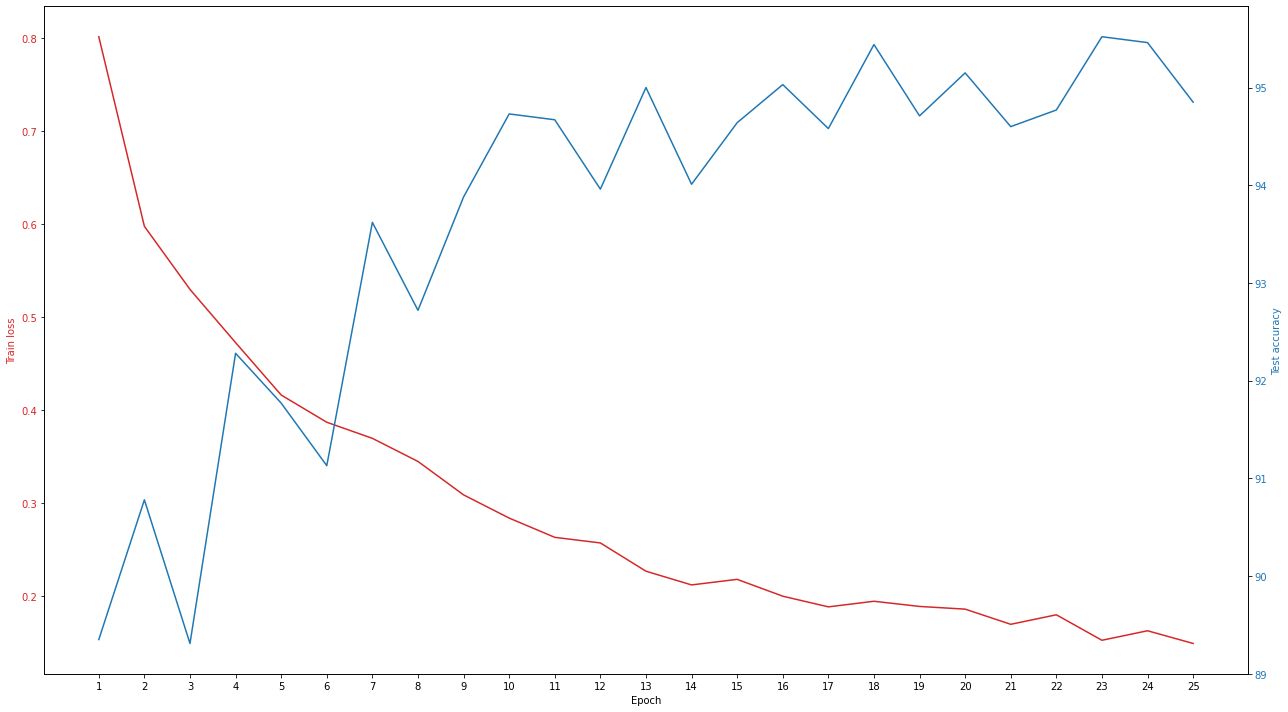

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_25.pth
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.161923
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.152778
Train Epoch: 26 [12800/60000 (21%)]	Loss: 0.095937
Train Epoch: 26 [19200/60000 (32%)]	Loss: 0.322325
Train Epoch: 26 [25600/60000 (43%)]	Loss: 0.103410
Train Epoch: 26 [32000/60000 (53%)]	Loss: 0.101394
Train Epoch: 26 [38400/60000 (64%)]	Loss: 0.200796
Train Epoch: 26 [44800/60000 (75%)]	Loss: 0.032600
Train Epoch: 26 [51200/60000 (85%)]	Loss: 0.089202
Train Epoch: 26 [57600/60000 (96%)]	Loss: 0.373643

Test set: Average loss: 0.0003, Accuracy: 9448/10000 (94%)

[0.16192318499088287, 0.26524215936660767, 0.011724283918738365, 0.31482091546058655, 0.23799212276935577, 0.21278059482574463, 0.1791563481092453, 0.4042195975780487, 0.014650415629148483, 0.31788161396980286, 0.30734845995903015, 0.04067034274339676, 0.16442780196666718, 0.10631562769412994, 0.4424205720424652, 0.3298095762729645, 0.107692524

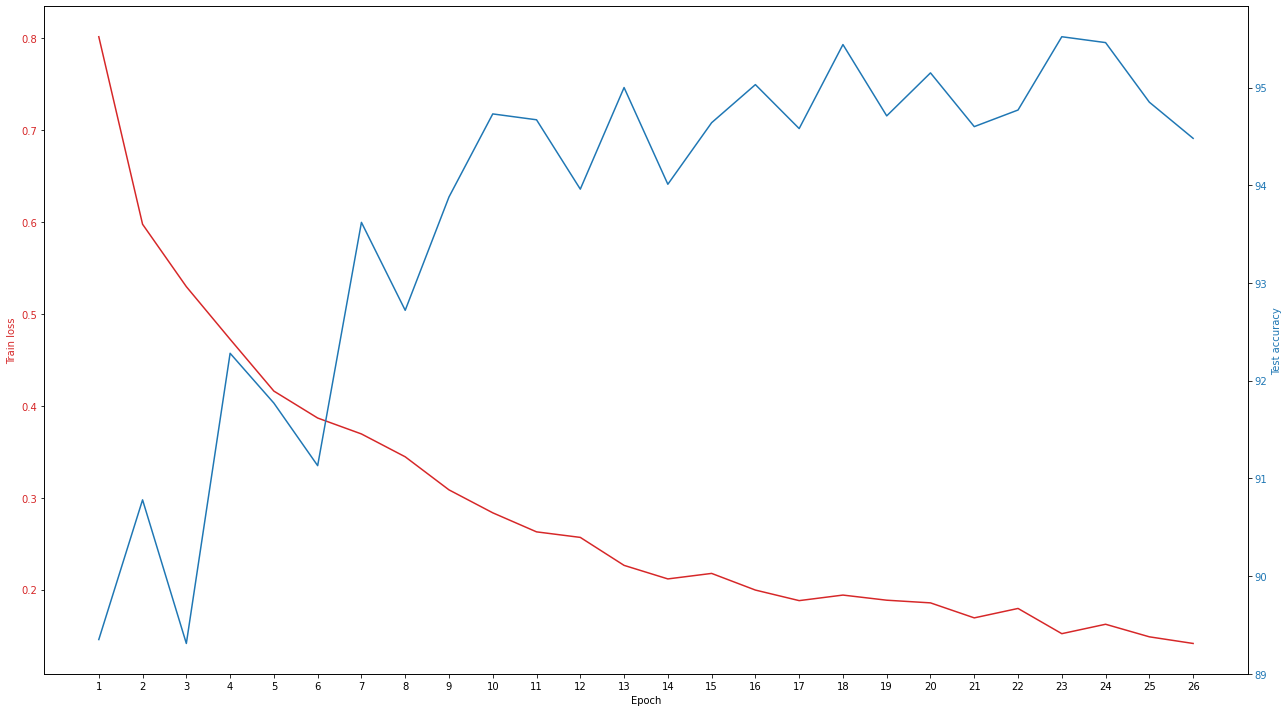

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_26.pth
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.547405
Train Epoch: 27 [6400/60000 (11%)]	Loss: 0.040476
Train Epoch: 27 [12800/60000 (21%)]	Loss: 0.126873
Train Epoch: 27 [19200/60000 (32%)]	Loss: 0.034992
Train Epoch: 27 [25600/60000 (43%)]	Loss: 0.143372
Train Epoch: 27 [32000/60000 (53%)]	Loss: 0.064445
Train Epoch: 27 [38400/60000 (64%)]	Loss: 0.301819
Train Epoch: 27 [44800/60000 (75%)]	Loss: 0.090474
Train Epoch: 27 [51200/60000 (85%)]	Loss: 0.034924
Train Epoch: 27 [57600/60000 (96%)]	Loss: 0.345625

Test set: Average loss: 0.0003, Accuracy: 9460/10000 (95%)

[0.5474047660827637, 0.017438417300581932, 0.09628507494926453, 0.1553238481283188, 0.0881207287311554, 0.27104365825653076, 0.042302291840314865, 0.017226509749889374, 0.33933961391448975, 0.3104776442050934, 0.2386743724346161, 0.01146202627569437, 0.012196691706776619, 0.04614006355404854, 0.3561597764492035, 0.06970985233783722, 0.202219590

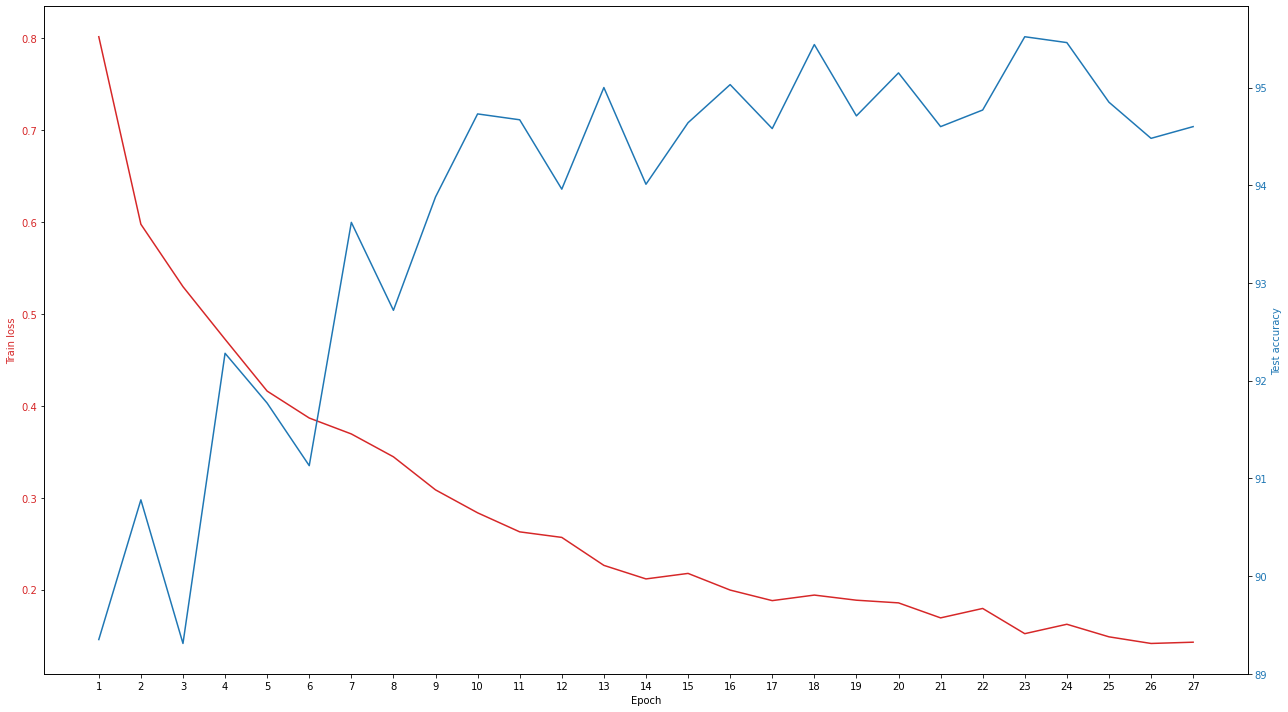

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_27.pth
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.140018
Train Epoch: 28 [6400/60000 (11%)]	Loss: 0.559134
Train Epoch: 28 [12800/60000 (21%)]	Loss: 0.101761
Train Epoch: 28 [19200/60000 (32%)]	Loss: 0.218884
Train Epoch: 28 [25600/60000 (43%)]	Loss: 0.012025
Train Epoch: 28 [32000/60000 (53%)]	Loss: 0.134390
Train Epoch: 28 [38400/60000 (64%)]	Loss: 0.050850
Train Epoch: 28 [44800/60000 (75%)]	Loss: 0.106203
Train Epoch: 28 [51200/60000 (85%)]	Loss: 0.205412
Train Epoch: 28 [57600/60000 (96%)]	Loss: 0.341734

Test set: Average loss: 0.0003, Accuracy: 9491/10000 (95%)

[0.14001774787902832, 0.22657383978366852, 0.036276187747716904, 0.24866439402103424, 0.18560297787189484, 0.1833728700876236, 0.1848495900630951, 0.0933234766125679, 0.04693463072180748, 0.03773975744843483, 0.04703686758875847, 0.13238997757434845, 0.3138704299926758, 0.2446088194847107, 0.019128236919641495, 0.03741735965013504, 0.3327981233

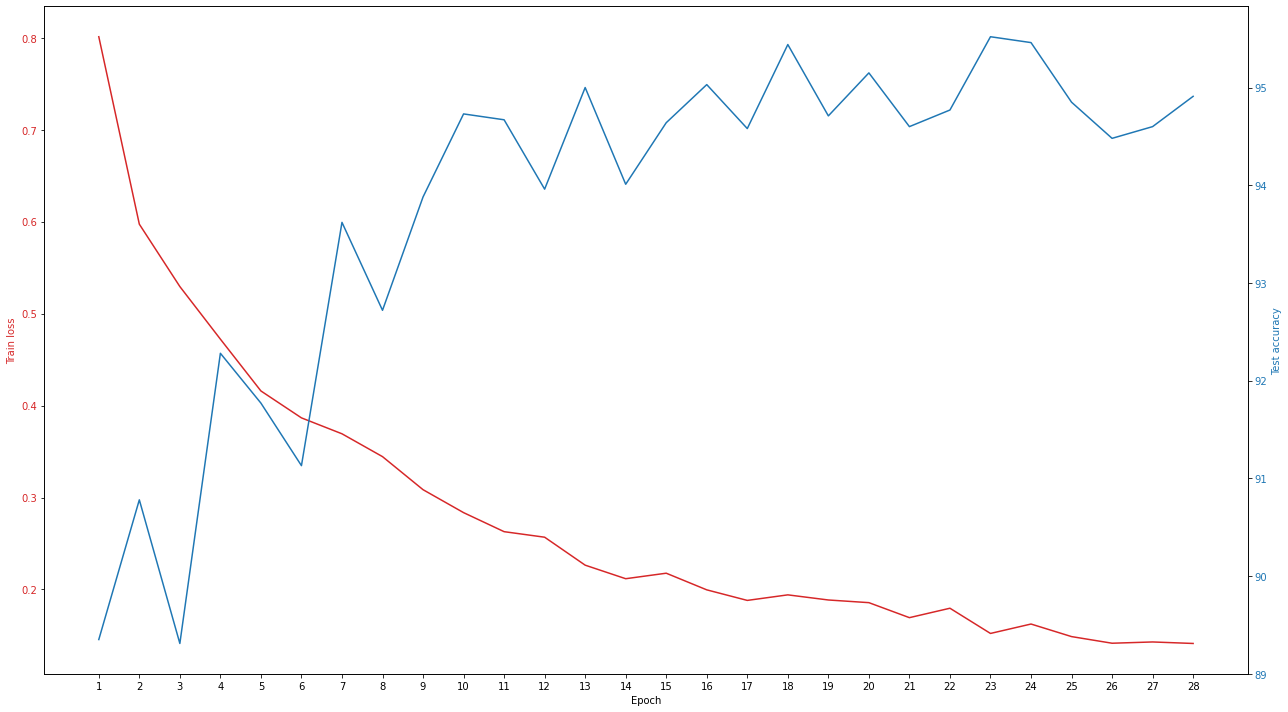

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_28.pth
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.083977
Train Epoch: 29 [6400/60000 (11%)]	Loss: 0.283586
Train Epoch: 29 [12800/60000 (21%)]	Loss: 0.001463
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.323112
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.048184
Train Epoch: 29 [32000/60000 (53%)]	Loss: 0.198870
Train Epoch: 29 [38400/60000 (64%)]	Loss: 0.040260
Train Epoch: 29 [44800/60000 (75%)]	Loss: 0.078806
Train Epoch: 29 [51200/60000 (85%)]	Loss: 0.062143
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.164498

Test set: Average loss: 0.0003, Accuracy: 9510/10000 (95%)

[0.08397743850946426, 0.17127469182014465, 0.00297000864520669, 0.13685660064220428, 0.14783409237861633, 0.049838703125715256, 0.06917156279087067, 0.2727578580379486, 0.007237100973725319, 0.04846722632646561, 0.2278486043214798, 0.08288788795471191, 0.023541301488876343, 0.029986592009663582, 0.07937467843294144, 0.032741349190473557, 0.1612

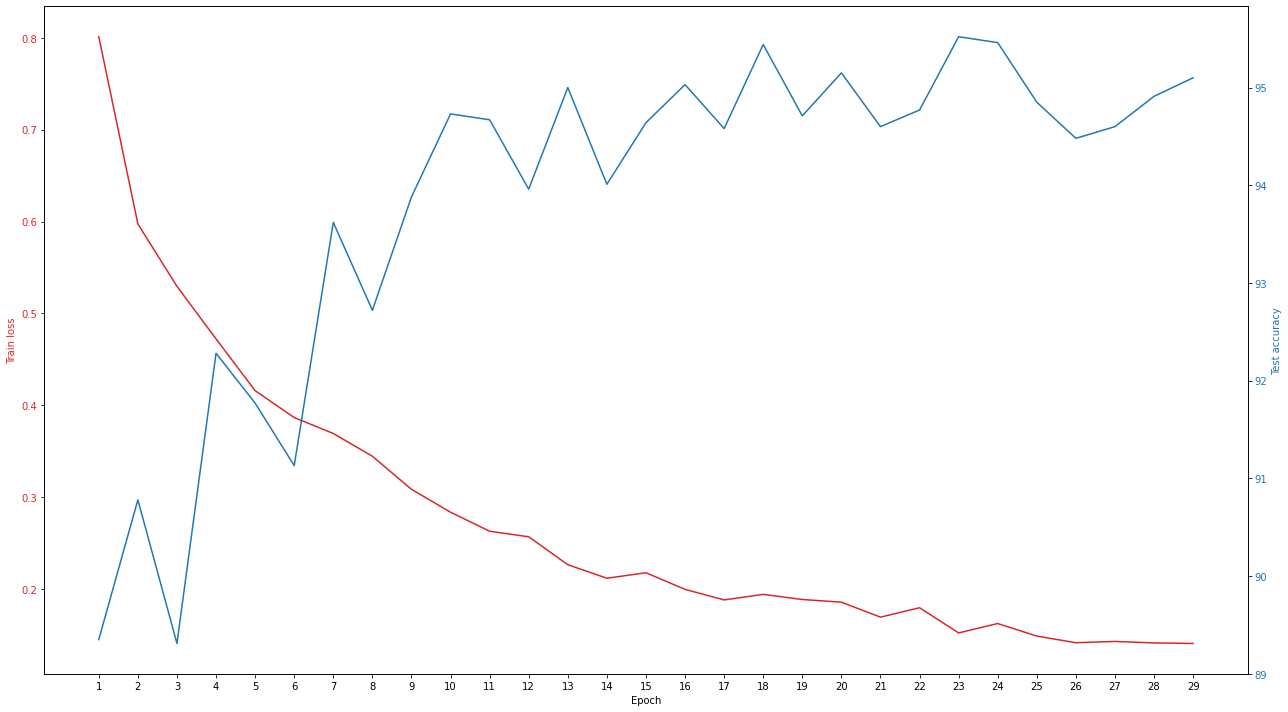

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_29.pth
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.378987
Train Epoch: 30 [6400/60000 (11%)]	Loss: 0.051882
Train Epoch: 30 [12800/60000 (21%)]	Loss: 0.102601
Train Epoch: 30 [19200/60000 (32%)]	Loss: 0.302536
Train Epoch: 30 [25600/60000 (43%)]	Loss: 0.034658
Train Epoch: 30 [32000/60000 (53%)]	Loss: 0.086782
Train Epoch: 30 [38400/60000 (64%)]	Loss: 0.038206
Train Epoch: 30 [44800/60000 (75%)]	Loss: 0.321947
Train Epoch: 30 [51200/60000 (85%)]	Loss: 0.128628
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.229804

Test set: Average loss: 0.0003, Accuracy: 9541/10000 (95%)

[0.37898707389831543, 0.19576385617256165, 0.0013287574984133244, 0.0009729281882755458, 0.11700400710105896, 0.025872625410556793, 0.13943493366241455, 0.3959272801876068, 0.27399685978889465, 0.006764179561287165, 0.03772112727165222, 0.0867389515042305, 0.3604882061481476, 0.26370784640312195, 0.0338631346821785, 0.015001787804067135, 0.1199

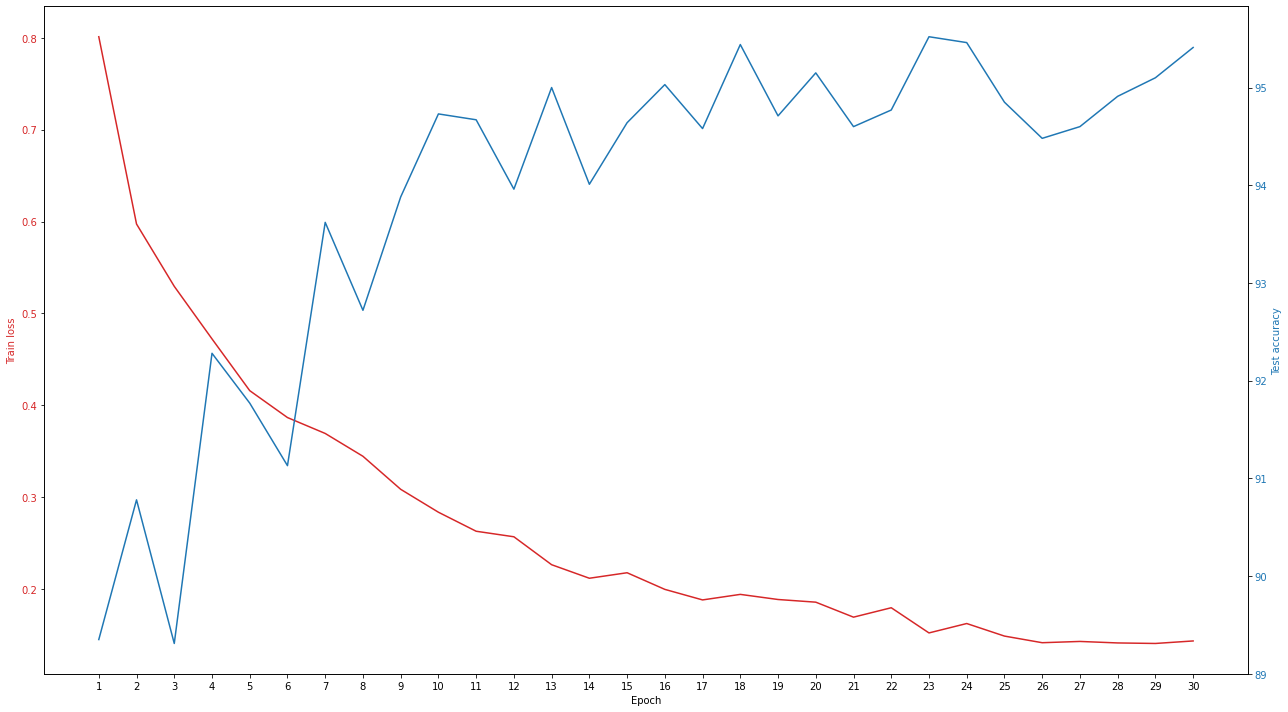

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_30.pth


In [76]:
test_accuracy_list = []
train_loss_list = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_accuracy = test()


    if epoch%40==0:
        optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1

    x_axis = np.arange(1,epoch+1)
    test_accuracy_list.append(test_accuracy)
    train_loss_list.append(np.mean(train_loss))
    # plt.plot()
    print(train_loss)
    print(train_loss_list)
    
    fig, ax1 = plt.subplots()
    x_axis = np.arange(1,epoch+1,dtype=int)
    fig.set_size_inches(18,10)

    ax1.set_xticks(x_axis)
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train loss', color=color)
    ax1.plot(x_axis, train_loss_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Test accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(x_axis, test_accuracy_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    model_path = os.path.join(models_path,f"epoch_{epoch}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"saved model {model_path}")


In [77]:
best_epoch = np.argmax(test_accuracy_list)+1
best_epoch

23

In [78]:
model_path = os.path.join(models_path,f"epoch_{best_epoch}.pth")
model = Net()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [79]:
model_path

'/shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/epoch_23.pth'

In [80]:
model_path = os.path.join(models_path,f"best.pth")
torch.save(model.state_dict(), model_path)
print(f"saved model {model_path}")

saved model /shares/bulk/earapidis/dev/BinarizedNN/saved_models/mlp/model_2/best.pth


In [83]:
if cuda:
    torch.cuda.set_device(0)
    model.cuda()
test()


Test set: Average loss: 0.0003, Accuracy: 9552/10000 (96%)



tensor(95.5200)